# Introduction: Business Problem

In this project we will try to find an optimal location for a new **Kebab Restaurant/Pizzeria/fast food place** in **Tampere**. Specifically, this report will be targeted to stakeholders interested in opening such a new place in Tampere, Finland. So this could be an opportunity for an immigrant to start a new bussiness or to get a job. Pizzerias also are run by Turkish or Kurdish people, but also by other people. Thus this project is also aimed to a larger population and franchising companies.

We are going to find out how many Kebab Restaurants/Pizzerias/fast food places there are in Tampere, and how they are located in different areas, neighbours, and boroughs. We are going to see **how many possible customers** are in the area, and try to find places with as **few competitors as possible**, and on the other hand find attractive places where people go, like **shops or bars in vicinity**.

We will use our data science powers to generate a few most promissing neighborhoods based on our criteria.

# Data

Based on definition of our problem, factors that will influence our decission are:
* number of existing kebab restaurants/pizzerias/fast food places or other restaurants in the neighborhood (any type of restaurant)
* number of people per kebab restaurants/pizzerias/fast food places or other restaurants in the neighborhood or borough
* number of competitors in the near vicinity, if any.
* number of shops around the kebab restaurant/pizzeria/fast food place/other restaurant
* number of bars around the kebab restaurant/pizzeria/fast food place/other restaurant.

### Data Sources
We get the following information from https://fi.wikipedia.org/wiki/Luettelo_Tampereen_tilastoalueista: neighbours, boroughs, planning area, the number of inhabitants in borough.

The location of the neigbours were mainly calculated using the Nominatim library of geopy.geocoders (not shown in this notebook, results saved to a local csv file). However, it does not give all the results, and the missing results were varying, and in some cases the result is not accurate. Therefore, in addition to geopy, also   open data available from https://geodata.tampere.fi/geoserver/kiinteistot/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=kiinteistot:NIMISTO_MVIEW&outputFormat=json is used. The coordinates are not in the form of latitudes and longitudes, but in the format: ETRS-GK24 (EPSG:3878). Coordinates can be changed by using a converter on the page https://kartta.paikkatietoikkuna.fi/?lang=fi.

The distances from neighbourhoods to the Tampere city center (Keskustori) is calculated by Google Maps (not shown in this notebook, results saved to a local csv file), using either distance by car, walk or bike. At the moment there are big tram constructions on the way to Tampere center, and the easiest way to get to the center is either by walk or by bus. Some traffic is only allowed for public traffic or taxis. Using your own car mean longer routes to get to the center. 

Radius information for each neighbourhood according to the size of the neighbourhood was estimated (results saved to a local csv file). This will be used as an information how far we are going to search places around the neighbouhood center. 

The number of kebab restaurants/pizzerias/fast food places and other restaurants and their type and location in every neighborhood will be obtained using Foursquare API. We also use that same api to get the number of competitors, shops and bars in the near vicinity of the kebab restaurants/pizzerias/fast food places and other restaurants.

#### Lets initialize/import libraries.

In [1]:
import pandas as pd
import numpy as np
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

Get geopy for address/coordinate conversions and folium for maps.

In [2]:
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

print('Nominatim installed and imported!')

!conda install -c conda-forge folium=0.5.0 --yes
import folium

print('Folium installed and imported!')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.6.16          |           py36_1         149 KB  conda-forge
    openssl-1.1.1c             |       h516909a_0         2.1 MB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    ca-certificates-2019.6.16  |       hecc5488_0         145 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.49-py_0         conda-forge
    geopy:           1.20.0-py_0       conda-forge

The following packages will be UPDATED:

    ca-

In [3]:
# Read the neighbourhoods.
HTMLPAGE = "https://fi.wikipedia.org/wiki/Luettelo_Tampereen_tilastoalueista"

data = pd.read_html(HTMLPAGE)

# See the len of the list
len(data)

1

In [4]:
df = data[0]
df.head()

Nimi Kaupunginosan numero   Suuralue Suunnittelualue Asukasluku
0      Aakkula                  NaN  Koillinen           Messu        481
1    Aitoniemi                  NaN  Pohjoinen            Aito        455
2  Ala-Pispala                  NaN  Lounainen         Pispala      1 097
3      Amuri A                   IV   Keskinen        Keskusta      3 119
4      Amuri B                    V   Keskinen        Keskusta      2 192

In [5]:
# Drop the not needed column
df = df.drop(['Kaupunginosan numero'], axis=1)
df.head()

Nimi   Suuralue Suunnittelualue Asukasluku
0      Aakkula  Koillinen           Messu        481
1    Aitoniemi  Pohjoinen            Aito        455
2  Ala-Pispala  Lounainen         Pispala      1 097
3      Amuri A   Keskinen        Keskusta      3 119
4      Amuri B   Keskinen        Keskusta      2 192

In [6]:
# Change the headers into English.
headers = ["Neighborhood","Borough","PlanningArea", "NumberOfPeople"]

df.columns = headers
df.head()

Neighborhood    Borough PlanningArea NumberOfPeople
0      Aakkula  Koillinen        Messu            481
1    Aitoniemi  Pohjoinen         Aito            455
2  Ala-Pispala  Lounainen      Pispala          1 097
3      Amuri A   Keskinen     Keskusta          3 119
4      Amuri B   Keskinen     Keskusta          2 192

In [7]:
# Check the unique boroughs.
df['Borough'].unique()

array(['Koillinen', 'Pohjoinen', 'Lounainen', 'Keskinen', 'Kaakkoinen',
       'Eteläinen', 'Luoteinen'], dtype=object)

In [8]:
# Translate boroughs into English
df.replace("Koillinen", "Northeastern", inplace = True)
df.replace("Pohjoinen", "Northern", inplace = True)
df.replace("Lounainen", "Southwestern", inplace = True)
df.replace("Keskinen", "Middle", inplace = True)
df.replace("Kaakkoinen", "Southeastern", inplace = True)
df.replace("Eteläinen", "Southern", inplace = True)
df.replace("Luoteinen", "Northwestern", inplace = True)
df.head(10)

Neighborhood       Borough PlanningArea NumberOfPeople
0      Aakkula  Northeastern        Messu            481
1    Aitoniemi      Northern         Aito            455
2  Ala-Pispala  Southwestern      Pispala          1 097
3      Amuri A        Middle     Keskusta          3 119
4      Amuri B        Middle     Keskusta          2 192
5        Atala  Northeastern         Tasa          4 629
6        Epilä  Southwestern         Raho          1 438
7  Epilänharju  Southwestern       Tesoma            909
8    Finlayson        Middle     Keskusta          1 607
9      Haihara  Southeastern        Kauka            184

In [9]:
# Change type and remove '\xa0' between numbers
df.replace(regex=['\xa0'], value='', inplace = True)
df[["NumberOfPeople"]] = df[["NumberOfPeople"]].astype("int")

#### Read from csv file information about the neihgbours
 
 * Latitude Neighborhood,Latitude,Longitude,Distance,Radius
 * Longitude
 * Distance from center (by car or public transportation or if close by walk)
 * Radius used to seek places nearby.


In [10]:
# The code was removed by Watson Studio for sharing.

Unnamed: 0 Neighborhood   Latitude  Longitude  Distance  Radius
0           0      Aakkula  61.484253  23.838243       5.6     370
1           1    Aitoniemi  61.567178  23.822284      23.9    4000
2           2  Ala-Pispala  61.505399  23.702884       3.5     600
3           3      Amuri A  61.499639  23.744413       1.0     370
4           4      Amuri B  61.499639  23.744413       1.0     370

In [11]:
# Transform type
df_data_14[["Radius"]] = df_data_14[["Radius"]].astype("int")

In [12]:
# Repair the data so that scandinavic characters are included.
coordinates_df = df_data_14
coordinates_df.replace(regex=['ae'], value='ä', inplace = True)
coordinates_df.replace(regex=['eo'], value='ö', inplace = True)

In [13]:
# Check changes.
coordinates_df.head(10)

Unnamed: 0 Neighborhood   Latitude  Longitude  Distance  Radius
0           0      Aakkula  61.484253  23.838243       5.6     370
1           1    Aitoniemi  61.567178  23.822284      23.9    4000
2           2  Ala-Pispala  61.505399  23.702884       3.5     600
3           3      Amuri A  61.499639  23.744413       1.0     370
4           4      Amuri B  61.499639  23.744413       1.0     370
5           5        Atala  61.503074  23.908347      10.4    1000
6           6        Epilä  61.505720  23.673316       5.5     780
7           7  Epilänharju  61.514067  23.659385       5.1     700
8           8    Finlayson  61.501933  23.755450       0.7     360
9           9      Haihara  61.475935  23.879479       8.3     500

In [14]:
# Remove the column Unnamed: 0.
coordinates_df = coordinates_df.drop(['Unnamed: 0'], axis=1)

#### Merge df and coordinates_df dataframes.

In [15]:
df = df.merge(coordinates_df, on="Neighborhood", how = 'inner')
df.head()

Neighborhood       Borough PlanningArea  NumberOfPeople   Latitude  \
0      Aakkula  Northeastern        Messu             481  61.484253   
1    Aitoniemi      Northern         Aito             455  61.567178   
2  Ala-Pispala  Southwestern      Pispala            1097  61.505399   
3      Amuri A        Middle     Keskusta            3119  61.499639   
4      Amuri B        Middle     Keskusta            2192  61.499639   

   Longitude  Distance  Radius  
0  23.838243       5.6     370  
1  23.822284      23.9    4000  
2  23.702884       3.5     600  
3  23.744413       1.0     370  
4  23.744413       1.0     370

Check if there are neighbourhoods with the same Latitude, Longitude.

In [16]:
apu = df.groupby(['Latitude','Longitude'],as_index=False).count()
apu2 = apu[apu['Neighborhood'] > 1]
apu2

Latitude  Longitude  Neighborhood  Borough  PlanningArea  NumberOfPeople  \
54  61.498341  23.768590             2        2             2               2   
60  61.499639  23.744413             2        2             2               2   
63  61.501752  23.780440             2        2             2               2   

    Distance  Radius  
54         2       2  
60         2       2  
63         2       2

Handle these three cases one at a time. 

In [17]:
# Check the first case.
apu3 = df[df['Latitude']== apu2.iloc[0,0] ]
apu3

Neighborhood Borough PlanningArea  NumberOfPeople   Latitude  Longitude  \
37    Kyttälä A  Middle     Keskusta            1558  61.498341   23.76859   
38    Kyttälä B  Middle     Keskusta            1796  61.498341   23.76859   

    Distance  Radius  
37      0.65     400  
38      0.65     400

In [18]:
# Lets join these two rows.
df.iloc[37, 3] = df.iloc[37, 3] + df.iloc[38, 3] # Calculate the number of people together.
df.iloc[37, 0] = 'Kyttälä' # Remove A from the end.

# Drop the other row.
df.drop([38], axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

# Check the result.
df[df['Neighborhood']== 'Kyttälä']

Neighborhood Borough PlanningArea  NumberOfPeople   Latitude  Longitude  \
37      Kyttälä  Middle     Keskusta            3354  61.498341   23.76859   

    Distance  Radius  
37      0.65     400

In [19]:
# Check the second case.
apu3 = df[df['Latitude']== apu2.iloc[1,0] ]
apu3

Neighborhood Borough PlanningArea  NumberOfPeople   Latitude  Longitude  \
3      Amuri A  Middle     Keskusta            3119  61.499639  23.744413   
4      Amuri B  Middle     Keskusta            2192  61.499639  23.744413   

   Distance  Radius  
3       1.0     370  
4       1.0     370

In [20]:
# Lets join these two rows.
df.iloc[3, 3] = df.iloc[3, 3] + df.iloc[4, 3]
df.iloc[3, 0] = 'Amuri'

# Drop row.
df.drop([4], axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

# Check the result.
df[df['Neighborhood']== 'Amuri']

Neighborhood Borough PlanningArea  NumberOfPeople   Latitude  Longitude  \
3        Amuri  Middle     Keskusta            5311  61.499639  23.744413   

   Distance  Radius  
3       1.0     370

In [21]:
# Check the third case.
apu3 = df[df['Latitude']== apu2.iloc[2,0] ]
apu3

Neighborhood Borough PlanningArea  NumberOfPeople   Latitude  Longitude  \
87    Tammela A  Middle     Keskusta            3257  61.501752   23.78044   
88    Tammela B  Middle     Keskusta            2307  61.501752   23.78044   

    Distance  Radius  
87       1.5     400  
88       1.5     400

In [22]:
# Lets join these two rows.
df.iloc[87, 3] = df.iloc[87, 3] + df.iloc[88, 3]
df.iloc[87, 0] = 'Tammela'

# Drop row.
df.drop([88], axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)

# Check the result.
df[df['Neighborhood']== 'Tammela']

Neighborhood Borough PlanningArea  NumberOfPeople   Latitude  Longitude  \
87      Tammela  Middle     Keskusta            5564  61.501752   23.78044   

    Distance  Radius  
87       1.5     400

In [23]:
# See the current row count
df.shape

(108, 8)

#### Display the neighbourhoods on the map. Draw a circle of radius 350 meters around each neighbourhood center.

In [24]:
import requests

# Fuction to get coordinates of an address.
def get_coordinates(address):
    try:
        geolocator = Nominatim(user_agent="ny_explorer")
        location = geolocator.geocode(address)
        lat = location.latitude
        lon = location.longitude
        return [lat, lon]
    except:
        return [None, None]

In [25]:
# Let's see the neihbourhoods in Tampere.
address = 'Tampere, Finland'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
lat = location.latitude
lng = location.longitude
tampere_lat = lat
tampere_lon = lng

map_tampere = folium.Map(location=[lat, lng], zoom_start=13)

label = "Tampere Center"
label = folium.Popup(label, parse_html=True)

folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tampere)  

#radius=300, color='blue', fill=False
for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tampere)  

    folium.Circle([lat, lng], radius=350, color='blue', fill=False).add_to(map_tampere)
map_tampere

#### Let's print the neigbourhoods where each neigbourhood is rounded by a specific circle read from the csv file. The radius corresponds to the size of the neihgbourhood.

In [26]:
map_tampere = folium.Map(location=[tampere_lat, tampere_lon], zoom_start=13)

for lat, lng, label, rad in zip(df['Latitude'], df['Longitude'], df['Neighborhood'], df['Radius']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_tampere)  

    folium.Circle([lat, lng], radius=rad, color='blue', fill=False).add_to(map_tampere)

map_tampere





We can see from the map that the circles cover quite well all the areas in Tampere.

### Foursquare
Now that we have our location candidates, let's use Foursquare API to get info on restaurants and kebab/pizzeria/fast food places in each neighborhood.

We're interested in venues in 'food' category, but especially of those that are pizza, kebab or fast places.

In [27]:
CLIENT_ID = 'W50MZ4A0IIT01JAB4YUM01AS1VSRLGRYRE5IXVKRW321Q40Z' # your Foursquare ID
CLIENT_SECRET = 'PAGF2BWZOUXRMFG4AE4DAPEQXYKYCGJ0ZJ5PJ4BBHXNVEMOI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [28]:
# Category IDs corresponding to restaurants were taken from Foursquare web site (https://developer.foursquare.com/docs/resources/categories):

food_category = '4d4b7105d754a06374d81259' # 'Root' category for all food-related venues

#1. Burger Joint
#4bf58dd8d48988d16c941735

#2. Fast Food Restaurant
#4bf58dd8d48988d16e941735

#3. Hot Dog Joint
#4bf58dd8d48988d16f941735

#4. Kebab Restaurant
#5283c7b4e4b094cb91ec88d7

#5. Pizza Place
#4bf58dd8d48988d1ca941735

#6. Snack Place
# 4bf58dd8d48988d1c7941735

#7. Doner Restaurant
# 5283c7b4e4b094cb91ec88d8


kebab_restaurant_categories = ['4bf58dd8d48988d16c941735', '4bf58dd8d48988d16e941735', '4bf58dd8d48988d16f941735',
                              '5283c7b4e4b094cb91ec88d7', '4bf58dd8d48988d1ca941735', '4bf58dd8d48988d1c7941735',
                              '5283c7b4e4b094cb91ec88d8']

def is_kebab_or_pizzeria_f(categories, specific_filter=None):
    wanted_foodplace_words = ['burger', 'fast food', 'hod dog', 'kebab', 'pizza', 'doner', 'snack']
    restaurant_words = ['restaurant', 'diner', 'taverna', 'steakhouse']
    kebab_or_pizzeria = False
    restaurant = False
    for c in categories:
        category_name = c[0].lower()
        category_id = c[1]
        for r in wanted_foodplace_words:
            if r in category_name:
                kebab_or_pizzeria = True
        if not(specific_filter is None) and (category_id in specific_filter):
            kebab_or_pizzeria = True
        
        # Check if the food place is restaurant
        if (kebab_or_pizzeria == False):
            for r in restaurant_words:
                if r in category_name:
                    restaurant = True
            if 'fast food' in category_name:
                restaurant = False
    return restaurant, kebab_or_pizzeria


def get_categories(categories):
    return [(cat['name'], cat['id']) for cat in categories]

def format_address(location):
    address = ', '.join(location['formattedAddress'])
    address = address.replace(', Suomi', '')
    address = address.replace(', Finland', '')
    return address

def get_venues_near_location(lat, lng, category, client_id, client_secret, radius, limit=2000):
    version = '20180724'
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
        client_id, client_secret, version, lat, lng, category, radius, limit)
    try:
        results = requests.get(url).json()['response']['groups'][0]['items']
        venues = [(item['venue']['id'],
                   item['venue']['name'],
                   get_categories(item['venue']['categories']),
                   (item['venue']['location']['lat'], item['venue']['location']['lng']),
                   format_address(item['venue']['location']),
                   item['venue']['location']['distance'],
                   item['venue']['categories'][0]['name']) for item in results]        
    except:
        venues = []
    return venues

In [29]:
# Let's now go over our neighborhood locations and get nearby kebab/pizzeria/fast food places and on the other hand other restaurants.
# We include in addition to the neighbour name the number of people in neihgbourhood and use the specific radius.
def getNearbyVenues(neighbourhoods, boroughs, inhabitants, latitudes, longitudes, rads, category):
    LIMIT = 2000
    
    venues_list=[]
    for neighbourhood, borough, inhabitant_count, lat, lng, radius in zip(neighbourhoods, boroughs, inhabitants, latitudes, longitudes, rads):
        print(neighbourhood, radius)
        venues = get_venues_near_location(lat, lng, category, CLIENT_ID, CLIENT_SECRET, radius=radius, limit=2000)
        for venue in venues:
            venue_id = venue[0]
            venue_name = venue[1]
            venue_categories = venue[2]
            venue_latlon = venue[3]
            venue_address = venue[4]
            venue_distance = venue[5]
            venue_categoryname = venue[6]
            is_res, is_kebab_or_pizz = is_kebab_or_pizzeria_f(venue_categories, specific_filter=kebab_restaurant_categories)
            
            tampere = True
            word_list = venue_address.split()  # list of words
            last_word = word_list[-1]
            
            # Exlude the cities around Tampere.
            if "Nokia" in last_word:
                tampere = False
            if "Ylöjärvi" in last_word:
                tampere = False
            if "Pirkkala" in last_word:
                tampere = False
            if "Kangasala" in last_word:
                tampere = False
            
            if ((is_kebab_or_pizz or is_res) and not tampere):
                print('exclude: {}, osoite: {}'.format(venue, venue_address))
        
            if ((is_kebab_or_pizz or is_res) and tampere):
                venues_list.append([(
                neighbourhood,
                borough,
                inhabitant_count,
                lat, 
                lng, 
                venue_name,
                venue_categoryname,
                venue_address,
                venue_latlon[0],
                venue_latlon[1],
                venue_distance,
                is_kebab_or_pizz,
                is_res, 
                venue_id)])
        

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                             'Borough',
                             'NumberOfPeople',
                             'Neighborhood Latitude',
                             'Neighborhood Longitude',
                             'Venue', 
                             'Venue Category',
                             'Venue Address',
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Distance',
                             'KebabOrPizzeria',
                             'Restaurant',
                             'Venue Id']
    
    return(nearby_venues)


Retrieve the venues. We search venues according to the specific radius area given to the neighbour.

In [30]:

tampere_venues = getNearbyVenues(neighbourhoods=df['Neighborhood'],
                                 boroughs=df['Borough'],
                                 inhabitants= df['NumberOfPeople'],
                                 latitudes=df['Latitude'],
                                 longitudes=df['Longitude'],
                                 rads=df['Radius'],
                                 category = food_category)


Aakkula 370
Aitoniemi 4000
Ala-Pispala 600
Amuri 370
Atala 1000
Epilä 780
Epilänharju 700
Finlayson 360
Haihara 500
Hakametsä 600
Hallila 750
Hankkio 750
Hatanpää 1000
Haukiluoma 800
Hervanta 1500
Hervantajärvi 700
Holvasti 1000
Huikas 650
Hyhky 700
Härmälä 1200
exclude: ('4d4afc35183f224b2d0feea8', 'Pizzeria Partola', [('Pizza Place', '4bf58dd8d48988d1ca941735')], (61.4701460613322, 23.722198004865454), 'Karhumäentie 1 (Nuolialantie), Pirkkala', 908, 'Pizza Place'), osoite: Karhumäentie 1 (Nuolialantie), Pirkkala
exclude: ('507bfa70e4b0da2386a996ad', 'Loon Fung', [('Chinese Restaurant', '4bf58dd8d48988d145941735')], (61.469348146285576, 23.71721405254592), 'Kenkätie 4, Pirkkala', 1180, 'Chinese Restaurant'), osoite: Kenkätie 4, Pirkkala
exclude: ('58a6d9ad8ae363643f5c5b0d', 'Ninan keittiö', [('Restaurant', '4bf58dd8d48988d1c4941735')], (61.467827, 23.723521), 'Kauppakeskus Veska (Saapastie 2), 33950 Pirkkala', 891, 'Restaurant'), osoite: Kauppakeskus Veska (Saapastie 2), 33950 Pirkkal

In [31]:
# List the venues.
tampere_venues


Neighborhood       Borough  NumberOfPeople  Neighborhood Latitude  \
0        Aakkula  Northeastern             481              61.484253   
1      Aitoniemi      Northern             455              61.567178   
2    Ala-Pispala  Southwestern            1097              61.505399   
3    Ala-Pispala  Southwestern            1097              61.505399   
4    Ala-Pispala  Southwestern            1097              61.505399   
5    Ala-Pispala  Southwestern            1097              61.505399   
6          Amuri        Middle            5311              61.499639   
7          Amuri        Middle            5311              61.499639   
8          Amuri        Middle            5311              61.499639   
9          Amuri        Middle            5311              61.499639   
10         Amuri        Middle            5311              61.499639   
11         Atala  Northeastern            4629              61.503074   
12         Epilä  Southwestern            1438              61.505720   
13         Epilä  Southwestern            1438              61.505720   
14         Epilä  Southwestern            1438              61.505720   
15         Epilä  Southwestern            1438              61.505720   
16   Epilänharju  Southwestern             909              61.514067   
17   Epilänharju  Southwestern             909              61.514067   
18   Epilänharju  Southwestern             909              61.514067   
19   Epilänharju  Southwestern             909              61.514067   
20     Finlayson        Middle            1607              61.501933   
21     Finlayson        Middle            1607              61.501933   
22     Finlayson        Middle            1607              61.501933   
23     Finlayson        Middle            1607              61.501933   
24     Finlayson        Middle            1607              61.501933   
25     Finlayson        Middle            1607              61.501933   
26     Finlayson        Middle            1607              61.501933   
27     Finlayson        Middle            1607              61.501933   
28     Finlayson        Middle            1607              61.501933   
29     Finlayson        Middle            1607              61.501933   
..           ...           ...             ...                    ...   
542    Vehmainen  Northeastern            1816              61.477930   
543        Veisu      Southern            1515              61.469617   
544        Veisu      Southern            1515              61.469617   
545        Veisu      Southern            1515              61.469617   
546        Veisu      Southern            1515              61.469617   
547     Velaatta      Northern             400              61.744369   
548     Velaatta      Northern             400              61.744369   
549     Velaatta      Northern             400              61.744369   
550     Velaatta      Northern             400              61.744369   
551     Velaatta      Northern             400              61.744369   
552      Vihioja        Middle              53              61.477298   
553      Vihioja        Middle              53              61.477298   
554      Vihioja        Middle              53              61.477298   
555      Vihioja        Middle              53              61.477298   
556      Vihioja        Middle              53              61.477298   
557       Viiala  Southeastern            1668              61.473794   
558       Viiala  Southeastern            1668              61.473794   
559     Viinikka        Middle            1382              61.486531   
560     Viinikka        Middle            1382              61.486531   
561     Viinikka        Middle            1382              61.486531   
562     Viinikka        Middle            1382              61.486531   
563     Viinikka        Middle            1382              61.486531   
564   Viitapohja      Northern             245              61

In [32]:
# List the columns.
tampere_venues.columns

Index(['Neighborhood', 'Borough', 'NumberOfPeople', 'Neighborhood Latitude',
       'Neighborhood Longitude', 'Venue', 'Venue Category', 'Venue Address',
       'Venue Latitude', 'Venue Longitude', 'Venue Distance',
       'KebabOrPizzeria', 'Restaurant', 'Venue Id'],
      dtype='object')

#### Remove the multiple venues. Leave only the closest.

In [33]:
# Search for venues in several neigbourhoods. Leave only the closest
apu = tampere_venues.groupby(['Venue Id'],as_index=False).count()
apu2 = apu[apu['Neighborhood'] > 1]
apu2

Venue Id  Neighborhood  Borough  NumberOfPeople  \
0    4b49c2fdf964a520537326e3             2        2               2   
2    4b543132f964a52037b427e3             2        2               2   
4    4b5e24c3f964a520108029e3             2        2               2   
5    4b5eae46f964a520b99529e3             2        2               2   
6    4b616d95f964a5202e132ae3             2        2               2   
8    4b61d76df964a52059262ae3             2        2               2   
9    4b6942baf964a520279d2be3             2        2               2   
11   4b713771f964a520de3c2de3             2        2               2   
13   4b76d6f9f964a52024632ee3             2        2               2   
14   4b7a6b56f964a520512c2fe3             2        2               2   
17   4b7fde6ef964a520a54130e3             3        3               3   
18   4b800ee7f964a520494e30e3             3        3               3   
19   4b828620f964a520a0d630e3             2        2               2   
20   4b879175f964a52023c331e3             3        3               3   
22   4b93a305f964a520224b34e3             2        2               2   
23   4b96b5a2f964a52077df34e3             2        2               2   
26   4ba1c58af964a520a6cb37e3             3        3               3   
27   4ba75642f964a5207b8c39e3             2        2               2   
28   4ba9d951f964a520873a3ae3             2        2               2   
29   4baa17f9f964a520324a3ae3             3        3               3   
30   4baca754f964a5201b013be3             2        2               2   
32   4bad42cbf964a520343f3be3             2        2               2   
36   4baf7270f964a52075003ce3             3        3               3   
37   4bb461890cbcef3b15ee582a             2        2               2   
38   4bb7152fef159c745dcd76f7             2        2               2   
40   4bb8c075b35776b0682dc901             2        2               2   
42   4bc1978274a9a5931214d2f6             2        2               2   
44   4bc2abc3b492d13a42dfa760             3        3               3   
45   4bc2f20bb492d13aa210a860             2        2               2   
46   4bc30b5b2a89ef3b366ff488             2        2               2   
..                        ...           ...      ...             ...   
274  53bfcd74498e95ba027d461c             2        2               2   
275  5402f1f5498ebbc733016dba             2        2               2   
278  54253022498e5a95dd6d0904             3        3               3   
279  542d09e3498e224884d22af2             2        2               2   
280  543978ea498eee6cfb3db70e             2        2               2   
281  544135da498e6fee78961443             2        2               2   
283  545e0074498e953159546379             2        2               2   
285  54e3166f498e2dc6fb48012f             3        3               3   
286  5530025f498e44b9c15cd7da             2        2               2   
287  55487625498ec72294ab5b89             2        2               2   
288  554cdf1e498eb0c13b6aa40c             2        2               2   
292  55c16145498e73397e703071             2        2               2   
294  55d54a47498ee11ec74c05dc             3        3               3   
296  5629faa3498edb1ed82721ba             2        2               2   
297  562a705a498e979da99ab3ce             3        3               3   
299  56b64337498e9b6fd98c24c4             2        2               2   
301  56c70cd1cd10aa917f463817             2        2               2   
303  56cec7cacd10c5a62aa11363             2        2               2   
304  56e05502498e221ed26cf4cf             2        2               2   
305  570e1111cd10c6782e01e824             2        2               2   
307  57cab680498e111d1c65244d             3        3               3   
308  57cac265498eb8c813c5e34a             2        2               2   
309  582330dd26ca404b4123a6d2             2        2               2   
310  5839b20800841a1ae3822ca7             3        3         

In [34]:
# Go through the multiple venues. Leave only the one which is closest to the neighbourhood center.
for index, row in apu2.iterrows():
    # Get all the multiple venues of each row.
    venue_id = row['Venue Id']
    rows_multiple_venues = tampere_venues[tampere_venues['Venue Id'] == venue_id]
    minDistance = rows_multiple_venues['Venue Distance'].min()
    #for index2, row2 in rows_multiple_venues.iterrows():
    #    if (row['Venue Distance'] > minDistance):
    #print(tampere_venues[(tampere_venues['Venue Id'] == venue_id) & (tampere_venues['Venue Distance'] > minDistance)])
    # Get names of indexes where the distance in greater than the minimum.
    indexNames = tampere_venues[(tampere_venues['Venue Id'] == venue_id) & (tampere_venues['Venue Distance'] > minDistance)].index
    #print(index, indexNames)
    # Delete these row indexes from dataFrame
    tampere_venues.drop(indexNames , inplace=True)
    tampere_venues.reset_index(drop=True, inplace=True)

In [35]:
# Check that each venue belongs only to one neighbourhood.
# Search for venues in several neigbourhoods. Leave only the closest
apu = tampere_venues.groupby(['Venue Id'],as_index=False).count()
apu2 = apu[apu['Neighborhood'] > 1]
apu2

Empty DataFrame
Columns: [Venue Id, Neighborhood, Borough, NumberOfPeople, Neighborhood Latitude, Neighborhood Longitude, Venue, Venue Category, Venue Address, Venue Latitude, Venue Longitude, Venue Distance, KebabOrPizzeria, Restaurant]
Index: []

In [36]:
# Now check the remaining venues.
tampere_venues

Neighborhood       Borough  NumberOfPeople  Neighborhood Latitude  \
0      Aitoniemi      Northern             455              61.567178   
1    Ala-Pispala  Southwestern            1097              61.505399   
2    Ala-Pispala  Southwestern            1097              61.505399   
3          Amuri        Middle            5311              61.499639   
4          Amuri        Middle            5311              61.499639   
5          Atala  Northeastern            4629              61.503074   
6          Epilä  Southwestern            1438              61.505720   
7          Epilä  Southwestern            1438              61.505720   
8          Epilä  Southwestern            1438              61.505720   
9          Epilä  Southwestern            1438              61.505720   
10   Epilänharju  Southwestern             909              61.514067   
11     Finlayson        Middle            1607              61.501933   
12     Finlayson        Middle            1607              61.501933   
13     Finlayson        Middle            1607              61.501933   
14     Finlayson        Middle            1607              61.501933   
15     Finlayson        Middle            1607              61.501933   
16     Finlayson        Middle            1607              61.501933   
17     Finlayson        Middle            1607              61.501933   
18     Finlayson        Middle            1607              61.501933   
19     Finlayson        Middle            1607              61.501933   
20     Finlayson        Middle            1607              61.501933   
21     Finlayson        Middle            1607              61.501933   
22       Haihara  Southeastern             184              61.475935   
23     Hakametsä  Northeastern             819              61.489834   
24     Hakametsä  Northeastern             819              61.489834   
25     Hakametsä  Northeastern             819              61.489834   
26     Hakametsä  Northeastern             819              61.489834   
27       Hallila  Southeastern            2685              61.464759   
28       Hankkio  Northeastern             204              61.479032   
29      Hatanpää        Middle            2686              61.482560   
..           ...           ...             ...                    ...   
299        Tulli        Middle            1232              61.496894   
300        Tulli        Middle            1232              61.496894   
301        Tulli        Middle            1232              61.496894   
302        Tulli        Middle            1232              61.496894   
303        Tulli        Middle            1232              61.496894   
304        Tulli        Middle            1232              61.496894   
305        Tulli        Middle            1232              61.496894   
306      Turtola  Southeastern             836              61.477485   
307      Turtola  Southeastern             836              61.477485   
308     Uusikylä  Northeastern            1310              61.496544   
309     Uusikylä  Northeastern            1310              61.496544   
310     Uusikylä  Northeastern            1310              61.496544   
311     Uusikylä  Northeastern            1310              61.496544   
312    Vehmainen  Northeastern            1816              61.477930   
313        Veisu      Southern            1515              61.469617   
314        Veisu      Southern            1515              61.469617   
315     Velaatta      Northern             400              61.744369   
316     Velaatta      Northern             400              61.744369   
317      Vihioja        Middle              53              61.477298   
318      Vihioja        Middle              53              61.477298   
319       Viiala  Southeastern            1668              61.473794   
320     Viinikka        Middle            1382              61.486531   
321     Viinikka        Middle            1382              61

#### Lets visualize the kebab/pizzeria/fast food places on the map in red, and other restaurants in blue.

In [37]:
address = 'Tampere, Finland'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
lat = location.latitude
lng = location.longitude

map_tampere = folium.Map(location=[lat, lng], zoom_start=13)

for lat, lng, label, is_kebab_or_pizzeria, ven_address in zip(tampere_venues['Venue Latitude'], tampere_venues['Venue Longitude'], 
                           tampere_venues['Venue'], tampere_venues['KebabOrPizzeria'], tampere_venues['Venue Address']):
    label = label + ", " + ven_address
    label = folium.Popup(label, parse_html=True)
    color = 'red' if is_kebab_or_pizzeria else 'blue'
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color=color,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=1,
        parse_html=False).add_to(map_tampere)  

map_tampere









When investigating the map thorougly near Tampere boarders we can find that there are still two venues outside Tampere.
One is 'Jagin Kööki' which is clearly in Ylöjärvi, and the other is 'Kokkinurkkaus' whitch is just close to the border, and it locates in Kangasala.
We remove these venues.

In [38]:
indexName = tampere_venues[(tampere_venues['Venue'] == "Jagin Kööki")].index
#print(indexName)
tampere_venues.drop(indexName , inplace=True)
tampere_venues.reset_index(drop=True, inplace=True)
#
indexName = tampere_venues[(tampere_venues['Venue'] == "Kokkinurkkaus")].index
#print(indexName)
tampere_venues.drop(indexName , inplace=True)
tampere_venues.reset_index(drop=True, inplace=True)

In [39]:
# Lets check the current row count.
tampere_venues.shape

(327, 14)

### Count the number of shops and bars 100 meters around each kebab/pizza/fast food place or other restaurant.

In [40]:
# Add new columns:
tampere_venues['ShopCount'] = 0
tampere_venues['BarCount'] = 0

In [41]:
# Check the columns
print(tampere_venues.columns)
print(tampere_venues.columns[8])
print(tampere_venues.columns[9])
print(tampere_venues.columns[14])
print(tampere_venues.columns[15])


Index(['Neighborhood', 'Borough', 'NumberOfPeople', 'Neighborhood Latitude',
       'Neighborhood Longitude', 'Venue', 'Venue Category', 'Venue Address',
       'Venue Latitude', 'Venue Longitude', 'Venue Distance',
       'KebabOrPizzeria', 'Restaurant', 'Venue Id', 'ShopCount', 'BarCount'],
      dtype='object')
Venue Latitude
Venue Longitude
ShopCount
BarCount


#### Define functions

In [42]:
# Category IDs corresponding to shops were taken from Foursquare web site (https://developer.foursquare.com/docs/resources/categories):

shop_category = '4d4b7105d754a06378d81259' # 'Root' category for all shop-related venues
#1. Food & Drink Shop
# 4bf58dd8d48988d1f9941735
#2. Dairy Store
# 58daa1558bbb0b01f18ec1ca
#3. Grocery Store
# 4bf58dd8d48988d118951735
#4. Supermarket
# 52f2ab2ebcbc57f1066b8b46

shop_categories = ['4bf58dd8d48988d1f9941735', '58daa1558bbb0b01f18ec1ca', '4bf58dd8d48988d118951735',
                  '52f2ab2ebcbc57f1066b8b46']

def is_shop_place(categories, specific_filter=None):
    shop_words = ['shop', 'store', 'supermarket']
    isshop = False
    
    for c in categories:
        category_name = c[0].lower()
        category_id = c[1]
        for r in shop_words:
            if r in category_name:
                isshop = True
        if not(specific_filter is None) and (category_id in specific_filter):
            isshop = True
        
    return isshop

bar_category = '4bf58dd8d48988d116941735'
nightlife_category = '4d4b7105d754a06376d81259'
# 1. Bar
# 4bf58dd8d48988d116941735
# 2. Irish Pub
# 52e81612bcbc57f1066b7a06
# 3. Pub
# 4bf58dd8d48988d11b941735
# 4. Nightclub
# 4bf58dd8d48988d11f941735
bar_categories = ['4bf58dd8d48988d116941735', '4d4b7105d754a06376d81259', '52e81612bcbc57f1066b7a06', '4bf58dd8d48988d11b941735',
                 '4bf58dd8d48988d11f941735']
def is_bar_place(categories, specific_filter=None):
    shop_words = ['bar', 'pub', 'nightclub']
    isshop = False
    
    for c in categories:
        category_name = c[0].lower()
        category_id = c[1]
        for r in shop_words:
            if r in category_name:
                isshop = True
        if not(specific_filter is None) and (category_id in specific_filter):
            isshop = True
        
    return isshop

#### Get the shops around the venues.

In [43]:
for index, row in tampere_venues.iterrows():
    tampere_venues.iloc[index, 14] = 0
    lat = tampere_venues.iloc[index, 8]
    lon = tampere_venues.iloc[index, 9]
    shop_venues = get_venues_near_location(lat, lon, shop_category, CLIENT_ID, CLIENT_SECRET, radius=1000, limit=1000 )
    is_shop = False
    for venue in shop_venues:
            venue_id = venue[0]
            venue_name = venue[1]
            venue_categories = venue[2]
            venue_latlon = venue[3]
            venue_address = venue[4]
            venue_distance = venue[5]
            venue_categoryname = venue[6]
            is_shop = is_shop_place(venue_categories, specific_filter=shop_categories)
            
            if (is_shop):
                count = tampere_venues.iloc[index, 14]
                tampere_venues.iloc[index, 14] = count + 1
                print('Near {} there exist : {}, {}'.format(tampere_venues.iloc[index, 5], venue_name, venue_address))

Near Pizpala there exist : S-market Hyhky, Peurankuja 1, 33270 Tampere
Near Pizpala there exist : K-Market Haapalinna, Pispalan Valtatie 91, 33270 Tampere
Near Pizpala there exist : Sale, Pispalan Valtatie 2, 33250 Tampere
Near Kotipizza there exist : S-market Hyhky, Peurankuja 1, 33270 Tampere
Near Kotipizza there exist : K-Market Haapalinna, Pispalan Valtatie 91, 33270 Tampere
Near Kotipizza there exist : Sale, Pispalan Valtatie 2, 33250 Tampere
Near Cafe Aleksanterinpuisto there exist : Punnitse & Säästä, Kuninkaankatu 22-24, 33200 Tampere
Near Cafe Aleksanterinpuisto there exist : Suklaapuoti, Tallipiha (Kuninkaankatu 4), 33210 Tampere
Near Cafe Aleksanterinpuisto there exist : Sokos Herkku, Hämeenkatu 21, 33200 Tampere
Near Cafe Aleksanterinpuisto there exist : Puolenkuun Pelit, Hämeenkatu 17, 33200 Tampere
Near Cafe Aleksanterinpuisto there exist : Sale, Satakunnankatu 36, 33210 Tampere
Near Cafe Aleksanterinpuisto there exist : Varimport, Hämeenkatu 16 (Keskustori), 33200 Tamper

#### Get the bars around the venues.

In [44]:
for index, row in tampere_venues.iterrows():
    tampere_venues.iloc[index, 15] = 0
    lat = tampere_venues.iloc[index, 8]
    lon = tampere_venues.iloc[index, 9]
    bar_venues = get_venues_near_location(lat, lon, nightlife_category, CLIENT_ID, CLIENT_SECRET, radius=1000, limit=1000 )
    is_bar = False
    for venue in bar_venues:
            venue_id = venue[0]
            venue_name = venue[1]
            venue_categories = venue[2]
            venue_latlon = venue[3]
            venue_address = venue[4]
            venue_distance = venue[5]
            venue_categoryname = venue[6]
            is_bar = is_bar_place(venue_categories, specific_filter=bar_categories)
            
            if (is_bar):
                count = tampere_venues.iloc[index, 15]
                tampere_venues.iloc[index, 15] = count + 1
                print('In the vicinity of {} there exists: {}, {}'.format(tampere_venues.iloc[index, 5], venue_name, venue_address))

In the vicinity of Pizpala there exists: A La Pispala, Tampere
In the vicinity of Pizpala there exists: Bikini Bar, Suomi
In the vicinity of Pizpala there exists: Terassi Pub Yläkerta, pispalan valtatie 39, 33250 Tampere
In the vicinity of Kotipizza there exists: A La Pispala, Tampere
In the vicinity of Kotipizza there exists: Bikini Bar, Suomi
In the vicinity of Kotipizza there exists: Terassi Pub Yläkerta, pispalan valtatie 39, 33250 Tampere
In the vicinity of Cafe Aleksanterinpuisto there exists: Gastropub Tuulensuu, Hämeenpuisto 23 (Puutarhakatu), 33210 Tampere
In the vicinity of Cafe Aleksanterinpuisto there exists: Maja/Talo, Pirkankatu 1, Tampere
In the vicinity of Cafe Aleksanterinpuisto there exists: Ravintola Tuoppi, Pyynikintori 6, 33230 Tampere
In the vicinity of Cafe Aleksanterinpuisto there exists: Ohranjyvä, Näsilinnankatu 15, 33210 Tampere
In the vicinity of Cafe Aleksanterinpuisto there exists: Ukkometso, Kauppakatu 16 (Hämeenpuisto), Tampere
In the vicinity of Cafe Al

### Count the number of competitors 100 meters around each venue.

In [45]:
# Add new columns:
tampere_venues['fast_food_competitor_count'] = 0
tampere_venues['restaurant_competitor_count'] = 0


In [46]:
print(tampere_venues.columns[13])
print(tampere_venues.columns[16])
print(tampere_venues.columns[17])

Venue Id
fast_food_competitor_count
restaurant_competitor_count


In [47]:
# Count the competitors 100 meters around each venue
for index, row in tampere_venues.iterrows():
    tampere_venues.iloc[index, 16] = 0
    tampere_venues.iloc[index, 17] = 0
    lat = tampere_venues.iloc[index, 8]
    lon = tampere_venues.iloc[index, 9]
    own_id = tampere_venues.iloc[index, 13]
    bar_venues = get_venues_near_location(lat, lon, food_category, CLIENT_ID, CLIENT_SECRET, radius=1000, limit=1000 )
    
    for venue in bar_venues:
            venue_id = venue[0]
            venue_name = venue[1]
            venue_categories = venue[2]
            venue_latlon = venue[3]
            venue_address = venue[4]
            venue_distance = venue[5]
            venue_categoryname = venue[6]
            is_res, is_kebab_or_pizz = is_kebab_or_pizzeria_f(venue_categories, specific_filter=kebab_restaurant_categories)
            
            # Do dot take the venue itself.
            if (is_kebab_or_pizz and (own_id != venue_id)):
                count = tampere_venues.iloc[index, 16]
                tampere_venues.iloc[index, 16] = count + 1
                print('In the vicinity of {} there exists a competitor: {}, {}'.format(tampere_venues.iloc[index, 5], venue_name, venue_address))
            if (is_res):
                count = tampere_venues.iloc[index, 17]
                tampere_venues.iloc[index, 17] = count + 1
                print('In the vicinity of {} there exists a competitor: {}, {}'.format(tampere_venues.iloc[index, 5], venue_name, venue_address))

In the vicinity of Pizpala there exists a competitor: Pispalan Pulteri, Pispalan Valtatie 23, 33250 Tampere
In the vicinity of Pizpala there exists a competitor: Vaakon Nakki, Pispalan valtatie 37, 33250 Tampere
In the vicinity of Pizpala there exists a competitor: Kotipizza, Pispalanvaltatie 73 B, 33250 Tampere
In the vicinity of Pizpala there exists a competitor: Hesburger, Pispalan Valtatie 54, 33270 Tampere
In the vicinity of Pizpala there exists a competitor: Kokkipoika, Suomi
In the vicinity of Pizpala there exists a competitor: Pizza & Kebab Rozerina, Pispalan Valtatie 56, Tampere
In the vicinity of Kotipizza there exists a competitor: Pispalan Pulteri, Pispalan Valtatie 23, 33250 Tampere
In the vicinity of Kotipizza there exists a competitor: Vaakon Nakki, Pispalan valtatie 37, 33250 Tampere
In the vicinity of Kotipizza there exists a competitor: Pizpala, Pispalan valtatie 28, 33250 Tampere
In the vicinity of Kotipizza there exists a competitor: Hesburger, Pispalan Valtatie 54,

#### Lets fetch all the shops in Tampere area.

In [48]:
# Let's go over our neighborhood locations and get nearby shops.
def getNearbyVenues3(neighbourhoods, boroughs, inhabitants, latitudes, longitudes, rads, category):
    LIMIT = 2000
    
    venues_list=[]
    for neighbourhood, borough, inhabitant_count, lat, lng, radius in zip(neighbourhoods, boroughs, inhabitants, latitudes, longitudes, rads):
        print(neighbourhood, radius)
        venues = get_venues_near_location(lat, lng, category, CLIENT_ID, CLIENT_SECRET, radius=radius, limit=2000)
        for venue in venues:
            venue_id = venue[0]
            venue_name = venue[1]
            venue_categories = venue[2]
            venue_latlon = venue[3]
            venue_address = venue[4]
            venue_distance = venue[5]
            venue_categoryname = venue[6]
            is_shop = is_shop_place(venue_categories, specific_filter=shop_categories)
            
            tampere = True
            word_list = venue_address.split()  # list of words
            last_word = word_list[-1]
            
            # Exlude the cities around Tampere.
            if "Nokia" in last_word:
                tampere = False
            if "Ylöjärvi" in last_word:
                tampere = False
            if "Pirkkala" in last_word:
                tampere = False
            if "Kangasala" in last_word:
                tampere = False
            
            if (is_shop and not tampere):
                print('exclude: {}, osoite: {}'.format(venue, venue_address))
        
            if (is_shop and tampere):
                venues_list.append([(
                neighbourhood,
                borough,
                inhabitant_count,
                lat, 
                lng, 
                venue_name,
                venue_categoryname,
                venue_address,
                venue_latlon[0],
                venue_latlon[1],
                venue_distance,
                venue_id)])

    nearby_venues3 = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues3.columns = ['Neighborhood',
                             'Borough',
                             'NumberOfPeople',
                             'Neighborhood Latitude',
                             'Neighborhood Longitude',
                             'Venue', 
                             'Venue Category',
                             'Venue Address',
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Distance',
                             'Venue Id']
    
    return(nearby_venues3)

In [49]:
shop_venues = getNearbyVenues3(neighbourhoods=df['Neighborhood'],
                                 boroughs=df['Borough'],
                                 inhabitants= df['NumberOfPeople'],
                                 latitudes=df['Latitude'],
                                 longitudes=df['Longitude'],
                                 rads=df['Radius'],
                                 category = shop_category)

Aakkula 370
Aitoniemi 4000
Ala-Pispala 600
Amuri 370
Atala 1000
Epilä 780
Epilänharju 700
Finlayson 360
Haihara 500
Hakametsä 600
Hallila 750
Hankkio 750
Hatanpää 1000
Haukiluoma 800
Hervanta 1500
Hervantajärvi 700
Holvasti 1000
Huikas 650
Hyhky 700
Härmälä 1200
exclude: ('4b8bd942f964a5207aae32e3', 'Verkkokauppa.com', [('Electronics Store', '4bf58dd8d48988d122951735')], (61.46753001610297, 23.721258209293307), 'Veska (Saapastie 2), 33950 Pirkkala', 1015, 'Electronics Store'), osoite: Veska (Saapastie 2), 33950 Pirkkala
exclude: ('4bdfb8650ee3a593fb3d35b0', 'K-Citymarket', [('Supermarket', '52f2ab2ebcbc57f1066b8b46')], (61.46577060307988, 23.7228736621547), 'Palmrothintie 2, 33950 Pirkkala', 1022, 'Supermarket'), osoite: Palmrothintie 2, 33950 Pirkkala
exclude: ('4bae10c3f964a52043803be3', 'H&M', [('Clothing Store', '4bf58dd8d48988d103951735')], (61.46791787605287, 23.71986137770364), 'Saapastie 2 (Saapastie 2), 33950 Pirkkala', 1073, 'Clothing Store'), osoite: Saapastie 2 (Saapastie 2

In [50]:
# List the results.
shop_venues

Neighborhood       Borough  NumberOfPeople  Neighborhood Latitude  \
0        Aakkula  Northeastern             481              61.484253   
1        Aakkula  Northeastern             481              61.484253   
2        Aakkula  Northeastern             481              61.484253   
3        Aakkula  Northeastern             481              61.484253   
4        Aakkula  Northeastern             481              61.484253   
5        Aakkula  Northeastern             481              61.484253   
6        Aakkula  Northeastern             481              61.484253   
7        Aakkula  Northeastern             481              61.484253   
8      Aitoniemi      Northern             455              61.567178   
9    Ala-Pispala  Southwestern            1097              61.505399   
10   Ala-Pispala  Southwestern            1097              61.505399   
11   Ala-Pispala  Southwestern            1097              61.505399   
12   Ala-Pispala  Southwestern            1097              61.505399   
13         Amuri        Middle            5311              61.499639   
14         Amuri        Middle            5311              61.499639   
15         Amuri        Middle            5311              61.499639   
16         Amuri        Middle            5311              61.499639   
17         Amuri        Middle            5311              61.499639   
18         Amuri        Middle            5311              61.499639   
19         Amuri        Middle            5311              61.499639   
20         Epilä  Southwestern            1438              61.505720   
21         Epilä  Southwestern            1438              61.505720   
22         Epilä  Southwestern            1438              61.505720   
23         Epilä  Southwestern            1438              61.505720   
24         Epilä  Southwestern            1438              61.505720   
25         Epilä  Southwestern            1438              61.505720   
26   Epilänharju  Southwestern             909              61.514067   
27   Epilänharju  Southwestern             909              61.514067   
28   Epilänharju  Southwestern             909              61.514067   
29   Epilänharju  Southwestern             909              61.514067   
..           ...           ...             ...                    ...   
754     Velaatta      Northern             400              61.744369   
755     Velaatta      Northern             400              61.744369   
756      Vihioja        Middle              53              61.477298   
757      Vihioja        Middle              53              61.477298   
758      Vihioja        Middle              53              61.477298   
759      Vihioja        Middle              53              61.477298   
760      Vihioja        Middle              53              61.477298   
761      Vihioja        Middle              53              61.477298   
762      Vihioja        Middle              53              61.477298   
763     Viinikka        Middle            1382              61.486531   
764     Viinikka        Middle            1382              61.486531   
765     Viinikka        Middle            1382              61.486531   
766     Viinikka        Middle            1382              61.486531   
767     Viinikka        Middle            1382              61.486531   
768   Viitapohja      Northern             245              61.649688   
769      Villilä  Southwestern            1201              61.492933   
770      Villilä  Southwestern            1201              61.492933   
771      Villilä  Southwestern            1201              61.492933   
772      Villilä  Southwestern            1201              61.492933   
773      Villilä  Southwestern            1201              61.492933   
774    Vuohenoja        Middle             634              61.483423   
775       Vuores      Southern            1948              61.434749   
776       Vuores      Southern            1948              61

In [51]:
# Search for venues in several neigbourhoods. Leave only the closest
apu = shop_venues.groupby(['Venue Id'],as_index=False).count()
apu2 = apu[apu['Neighborhood'] > 1]
apu2

Venue Id  Neighborhood  Borough  NumberOfPeople  \
1    4b4de105f964a520fbd926e3             3        3               3   
2    4b540275f964a5206ab027e3             3        3               3   
4    4b5b1b5bf964a520ade328e3             2        2               2   
8    4b62c20bf964a5207b512ae3             2        2               2   
9    4b62f38cf964a520695a2ae3             3        3               3   
10   4b63f004f964a520de972ae3             2        2               2   
11   4b6453f7f964a520ecaa2ae3             2        2               2   
12   4b64566bf964a5209cab2ae3             3        3               3   
15   4b6ebcb9f964a52065c82ce3             3        3               3   
21   4b8aa84ff964a520fc7732e3             3        3               3   
24   4b9cdd6cf964a5206e7f36e3             2        2               2   
27   4baa3969f964a52019553ae3             3        3               3   
28   4bb0ccf4f964a520295e3ce3             2        2               2   
31   4bbc23333de8c9b697b29aad             3        3               3   
34   4bc03ee7461576b0d7ef7932             2        2               2   
35   4bc04fcdf8219c74386cb110             4        4               4   
36   4bc0531bb492d13a961ca460             2        2               2   
37   4bc07029abf495217936bf93             2        2               2   
40   4bc2e5c5abf495213708c393             3        3               3   
42   4bc436bab492d13accbba960             4        4               4   
43   4bc445b3b492d13a1ec7a960             3        3               3   
44   4bc46076461576b058c77f32             2        2               2   
45   4bc46479b492d13a8beaa960             2        2               2   
49   4bd1643141b9ef3b37dffbe5             3        3               3   
50   4bd2b0fd9854d13a7f34fc4d             3        3               3   
51   4bd80f6335aad13a67ff8ff3             3        3               3   
54   4bdfc30be75c0f470648cc03             2        2               2   
55   4be184b5c1732d7f40395c9a             2        2               2   
56   4be2b02c660ec9286df0c93b             2        2               2   
57   4be54ef82468c928c2dcff42             2        2               2   
..                        ...           ...      ...             ...   
398  53808868498e54e075c70f57             2        2               2   
401  539ec541498e0d932e897756             2        2               2   
403  5448f869498e1cf931cf0580             3        3               3   
405  54b80d29498e6d4f36172094             2        2               2   
407  550b2c71498eb6354ae82441             3        3               3   
408  553273d8498ea9b85fd39c13             2        2               2   
412  559eac26498eb56950aa6e0e             2        2               2   
416  569511c1498e1b935936cde5             3        3               3   
421  5749710b498e49a136144f92             3        3               3   
422  57505cf338faf042a8e9e2c0             3        3               3   
423  5784cef4498efaf11246f610             2        2               2   
425  57b57f45498e10081da1c0cb             3        3               3   
428  5810a46738fa1fec80ec4787             3        3               3   
430  583b4a1ed439073da7923baf             2        2               2   
432  5888d0d3790bea46fa867989             2        2               2   
434  58cb87a75804ea7c2685b59e             2        2               2   
435  58d96ae3102f4722b7005f2c             3        3               3   
436  58dba33b0b56566d444eafae             2        2               2   
437  58e788496431e55859f8eef8             3        3               3   
439  58fa1120a35dce24a1709518             2        2               2   
441  59428a791fa7633bd7536332             3        3               3   
442  59450269ca18ea35e6255046             2        2               2   
443  59895e72a9fe1212d749ad1e             3        3               3   
445  5a11d0a86fd62668f8b7116e             2        2         

In [52]:
# Go through the multiple venues. Leave only the one which is closest to the neighbourhood center.
for index, row in apu2.iterrows():
    # Get all the multiple venues of each row.
    venue_id = row['Venue Id']
    rows_multiple_venues = shop_venues[shop_venues['Venue Id'] == venue_id]
    minDistance = rows_multiple_venues['Venue Distance'].min()
    
    # Get names of indexes where the distance in greater than the minimum.
    indexNames = shop_venues[(shop_venues['Venue Id'] == venue_id) & (shop_venues['Venue Distance'] > minDistance)].index
    # Delete these row indexes from dataFrame
    shop_venues.drop(indexNames , inplace=True)
    shop_venues.reset_index(drop=True, inplace=True)

In [53]:
# Check the result.
apu = shop_venues.groupby(['Venue Id'],as_index=False).count()
apu2 = apu[apu['Neighborhood'] > 1]
apu2

Empty DataFrame
Columns: [Venue Id, Neighborhood, Borough, NumberOfPeople, Neighborhood Latitude, Neighborhood Longitude, Venue, Venue Category, Venue Address, Venue Latitude, Venue Longitude, Venue Distance]
Index: []

In [54]:
# Lets group the result by neigbourhood.
shop_venues_grouped = shop_venues.groupby(['Neighborhood']).count()
shop_venues_grouped


Borough  NumberOfPeople  Neighborhood Latitude  \
Neighborhood                                                   
Aakkula             8               8                      8   
Aitoniemi           1               1                      1   
Ala-Pispala         2               2                      2   
Amuri               4               4                      4   
Epilä               5               5                      5   
Epilänharju         3               3                      3   
Finlayson          21              21                     21   
Haihara             2               2                      2   
Hakametsä          14              14                     14   
Hallila             3               3                      3   
Hatanpää            1               1                      1   
Haukiluoma          1               1                      1   
Hervanta           24              24                     24   
Holvasti            1               1                      1   
Huikas              1               1                      1   
Hyhky               2               2                      2   
Härmälä             3               3                      3   
Ikuri               1               1                      1   
Jokipohja           3               3                      3   
Jussinkylä          4               4                      4   
Järvensivu          2               2                      2   
Kaakinmaa           2               2                      2   
Kaleva              5               5                      5   
Kalevanharju        1               1                      1   
Kalevanrinne        6               6                      6   
Kalkku              4               4                      4   
Kaukajärvi          4               4                      4   
Kissanmaa           2               2                      2   
Kyttälä            61              61                     61   
Kämmenniemi         1               1                      1   
...               ...             ...                    ...   
Rahola              1               1                      1   
Rantaperkiö         1               1                      1   
Ratina             43              43                     43   
Rautaharkko         2               2                      2   
Ristinarkku         1               1                      1   
Ruotula             2               2                      2   
Rusko               2               2                      2   
Santalahti          2               2                      2   
Sarankulma          4               4                      4   
Särkänniemi         2               2                      2   
Taatala             5               5                      5   
Tahmela             4               4                      4   
Takahuhti           2               2                      2   
Tammela             9               9                      9   
Tammerkoski        33              33                     33   
Tampella            3               3                      3   
Tasanne             1               1                      1   
Terälahti           2               2                      2   
Tesomajärvi         5               5                      5   
Tulli              21              21                     21   
Turtola            10              10                     10   
Uusikylä            2               2                      2   
Vehmainen           1               1                      1   
Veisu               2               2                      2   
Velaatta            1               1                      1   
Vihioja             4               4                      4   
Viinikka            3               3                      3   
Villilä             5               5                      5   
Vuores              3               3                      3   
Ylä-Pispala         3               3         

In [55]:
shop_venues_grouped2 = shop_venues_grouped
shop_venues_grouped2.reset_index()
#lista = shop_venues_grouped2['Neighborhood'].tolist()
#lista
shop_venues_grouped2.index
s = set(shop_venues_grouped2.index)
s_all = set(df['Neighborhood'].tolist())
# difference 
print("Possible there are no shops in :", s_all - s) 

Possible there are no shops in : {'Pappila', 'Koivistonkylä', 'Polso', 'Nirva', 'Petsamo', 'Lakalaiva', 'Korkinmäki', 'Kaarila', 'Lapinniemi', 'Kauppi', 'Hankkio', 'Atala', 'Ryydynpohja', 'Ojala', 'Sorila', 'Lintulampi', 'Kumpula', 'Pohtola', 'Vuohenoja', 'Ristimäki', 'Hervantajärvi', 'Tohloppi', 'Muotiala', 'Viitapohja', 'Niemenranta', 'Viiala'}


#### Lets get all the bars in Tampere.

In [56]:
# Let's go over our neighborhood locations and get nearby bars.
def getNearbyVenues4(neighbourhoods, boroughs, inhabitants, latitudes, longitudes, rads, category):
    LIMIT = 2000
    
    venues_list=[]
    for neighbourhood, borough, inhabitant_count, lat, lng, radius in zip(neighbourhoods, boroughs, inhabitants, latitudes, longitudes, rads):
        print(neighbourhood, radius)
        venues = get_venues_near_location(lat, lng, category, CLIENT_ID, CLIENT_SECRET, radius=radius, limit=2000)
        for venue in venues:
            venue_id = venue[0]
            venue_name = venue[1]
            venue_categories = venue[2]
            venue_latlon = venue[3]
            venue_address = venue[4]
            venue_distance = venue[5]
            venue_categoryname = venue[6]
            is_bar = is_bar_place(venue_categories, specific_filter=bar_categories)
            
            tampere = True
            word_list = venue_address.split()  # list of words
            last_word = word_list[-1]
            
            # Exlude the cities around Tampere.
            if "Nokia" in last_word:
                tampere = False
            if "Ylöjärvi" in last_word:
                tampere = False
            if "Pirkkala" in last_word:
                tampere = False
            if "Kangasala" in last_word:
                tampere = False
            
            if (is_bar and not tampere):
                print('exclude: {}, osoite: {}'.format(venue, venue_address))
        
            if (is_bar and tampere):
                venues_list.append([(
                neighbourhood,
                borough,
                inhabitant_count,
                lat, 
                lng, 
                venue_name,
                venue_categoryname,
                venue_address,
                venue_latlon[0],
                venue_latlon[1],
                venue_distance,
                venue_id)])

    nearby_venues4 = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues4.columns = ['Neighborhood',
                             'Borough',
                             'NumberOfPeople',
                             'Neighborhood Latitude',
                             'Neighborhood Longitude',
                             'Venue', 
                             'Venue Category',
                             'Venue Address',
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Distance',
                             'Venue Id']
    return(nearby_venues4)

In [57]:
bar_venues = getNearbyVenues4(neighbourhoods=df['Neighborhood'],
                                 boroughs=df['Borough'],
                                 inhabitants= df['NumberOfPeople'],
                                 latitudes=df['Latitude'],
                                 longitudes=df['Longitude'],
                                 rads=df['Radius'],
                                 category = bar_category)

Aakkula 370
Aitoniemi 4000
Ala-Pispala 600
Amuri 370
Atala 1000
Epilä 780
Epilänharju 700
Finlayson 360
Haihara 500
Hakametsä 600
Hallila 750
Hankkio 750
Hatanpää 1000
Haukiluoma 800
Hervanta 1500
Hervantajärvi 700
Holvasti 1000
Huikas 650
Hyhky 700
Härmälä 1200
Ikuri 1000
Jokipohja 700
Jussinkylä 350
Järvensivu 550
Kaakinmaa 370
Kaarila 1000
Kaleva 500
Kalevanharju 600
Kalevanrinne 500
Kalkku 1200
Kaukajärvi 1700
Kauppi 600
Kissanmaa 600
Koivistonkylä 800
Korkinmäki 650
Kumpula 700
Kyttälä 400
Kämmenniemi 5000
Lahdesjärvi 1300
Lakalaiva 800
Lamminpää 1000
exclude: ('5336d629498e3cecfa23c02c', 'Ravintola Paalupaikka (istumakatsomo)', [('Bar', '4bf58dd8d48988d116941735')], (61.528858372355224, 23.626274174151146), 'Teivon ravikeskus, 33420 Ylöjärvi', 824, 'Bar'), osoite: Teivon ravikeskus, 33420 Ylöjärvi
Lapinniemi 600
Lappi 550
Leinola 1200
exclude: ('4d7134f7722ef04d93da0d9c', 'Vehmas-Krouvi', [('Pub', '4bf58dd8d48988d11b941735')], (61.476878160221666, 23.927200923417285), 'Viertokatu

In [58]:
bar_venues

Neighborhood       Borough  NumberOfPeople  Neighborhood Latitude  \
0        Aakkula  Northeastern             481              61.484253   
1    Ala-Pispala  Southwestern            1097              61.505399   
2    Ala-Pispala  Southwestern            1097              61.505399   
3          Amuri        Middle            5311              61.499639   
4          Amuri        Middle            5311              61.499639   
5          Amuri        Middle            5311              61.499639   
6          Amuri        Middle            5311              61.499639   
7          Epilä  Southwestern            1438              61.505720   
8          Epilä  Southwestern            1438              61.505720   
9          Epilä  Southwestern            1438              61.505720   
10     Finlayson        Middle            1607              61.501933   
11     Finlayson        Middle            1607              61.501933   
12     Finlayson        Middle            1607              61.501933   
13     Finlayson        Middle            1607              61.501933   
14     Finlayson        Middle            1607              61.501933   
15       Haihara  Southeastern             184              61.475935   
16       Haihara  Southeastern             184              61.475935   
17       Haihara  Southeastern             184              61.475935   
18       Haihara  Southeastern             184              61.475935   
19     Hakametsä  Northeastern             819              61.489834   
20     Hakametsä  Northeastern             819              61.489834   
21     Hakametsä  Northeastern             819              61.489834   
22       Hallila  Southeastern            2685              61.464759   
23       Hallila  Southeastern            2685              61.464759   
24       Hankkio  Northeastern             204              61.479032   
25       Hankkio  Northeastern             204              61.479032   
26       Hankkio  Northeastern             204              61.479032   
27      Hatanpää        Middle            2686              61.482560   
28      Hatanpää        Middle            2686              61.482560   
29    Haukiluoma  Southwestern            1593              61.518774   
..           ...           ...             ...                    ...   
294     Tohloppi  Southwestern            2305              61.512601   
295        Tulli        Middle            1232              61.496894   
296        Tulli        Middle            1232              61.496894   
297        Tulli        Middle            1232              61.496894   
298        Tulli        Middle            1232              61.496894   
299        Tulli        Middle            1232              61.496894   
300        Tulli        Middle            1232              61.496894   
301        Tulli        Middle            1232              61.496894   
302        Tulli        Middle            1232              61.496894   
303        Tulli        Middle            1232              61.496894   
304        Tulli        Middle            1232              61.496894   
305        Tulli        Middle            1232              61.496894   
306     Uusikylä  Northeastern            1310              61.496544   
307     Uusikylä  Northeastern            1310              61.496544   
308     Uusikylä  Northeastern            1310              61.496544   
309     Uusikylä  Northeastern            1310              61.496544   
310    Vehmainen  Northeastern            1816              61.477930   
311    Vehmainen  Northeastern            1816              61.477930   
312    Vehmainen  Northeastern            1816              61.477930   
313     Velaatta      Northern             400              61.744369   
314     Velaatta      Northern             400              61.744369   
315      Vihioja        Middle              53              61.477298   
316       Viiala  Southeastern            1668              61

In [59]:
# Search for venues in several neigbourhoods. Leave only the closest
apu = bar_venues.groupby(['Venue Id'],as_index=False).count()
apu2 = apu[apu['Neighborhood'] > 1]
apu2

Venue Id  Neighborhood  Borough  NumberOfPeople  \
1    4b55d7abf964a5206cf227e3             2        2               2   
2    4b6df3fcf964a5208d9e2ce3             3        3               3   
5    4b86a447f964a520d09331e3             2        2               2   
6    4b894098f964a5201d2632e3             2        2               2   
7    4b8d81d1f964a520deff32e3             2        2               2   
10   4ba0b4cef964a520987837e3             3        3               3   
11   4ba0fdbdf964a520e28c37e3             2        2               2   
14   4bab9619f964a52082b63ae3             3        3               3   
16   4bae4367f964a5205c9a3be3             3        3               3   
19   4bae90f5f964a5206ac13be3             3        3               3   
20   4bb1dc91f964a52012a73ce3             3        3               3   
21   4bb3585ca32876b0278d01fe             2        2               2   
22   4bbf758930c99c748d3d5511             3        3               3   
27   4bc826c48b7c9c74c7ab37cf             2        2               2   
30   4bca2a02fb84c9b6ac931c3e             3        3               3   
31   4bd6f35a637ba5938ff2f870             4        4               4   
32   4bd8896835aad13a752191f3             2        2               2   
33   4bdc35a363c5c9b6fcbf2a68             2        2               2   
36   4bf545996a31d13a45a7962e             2        2               2   
37   4bf827cdb182c9b64dfb765a             3        3               3   
38   4c03cde539d476b0198b30a7             2        2               2   
39   4c093df7340720a1ae708493             2        2               2   
40   4c0e95907189c92839bdd8b6             2        2               2   
42   4c1287d8a5eb76b0c259beb7             3        3               3   
43   4c1bcce4b9f876b0fadb7a46             2        2               2   
44   4c2a35a4fe6e2d7fc70f563c             2        2               2   
45   4c32111d16adc928a57cc19c             2        2               2   
46   4c53495bf5f3d13af5e239f8             2        2               2   
47   4c5999c12091a59364445dd0             3        3               3   
49   4c7022319375a093a1090637             3        3               3   
..                        ...           ...      ...             ...   
123  509e2d46e4b0a0263ea25d35             2        2               2   
124  50a61e13e4b0c08636a7d234             2        2               2   
125  50cd0496e4b05e3ef9aef8b2             2        2               2   
126  50d62b06e4b079e5ca719a5f             3        3               3   
127  510f79b7011ce960937fafad             2        2               2   
128  51434727e4b0ebd4ebadfca3             4        4               4   
129  5144e89ee4b0ec7324c4d7a9             2        2               2   
130  5144ed1ae4b016fae5d8bb78             3        3               3   
133  51586633e4b0226ab997578e             3        3               3   
134  51601296e4b082ab14a96480             3        3               3   
136  5166e1d7e4b0bf926d88bbb7             2        2               2   
138  518a7e5b498eb64d2a37e094             2        2               2   
140  519619f9498ef1d815604255             2        2               2   
141  52759f0a11d216db74d667d1             2        2               2   
142  52963ebc498e793de92a66c7             2        2               2   
143  5297059711d20f2ed8050f63             2        2               2   
144  52a0f38911d20f02f5c604da             2        2               2   
145  52c6dce0498e9a374bfedc6c             3        3               3   
146  52d39a8f498e92b319574a30             2        2               2   
147  5307932c11d26bb27386c9b4             3        3               3   
149  53c072f4498e27a169b38720             2        2               2   
150  53d2a33e498e0558e53dc556             2        2               2   
152  544154f3498e8a0187bb8bec             2        2               2   
153  54665ed4498e762c1d94d8a8             3        3         

In [60]:
# Go through the multiple venues. Leave only the one which is closest to the neighbourhood center.
for index, row in apu2.iterrows():
    # Get all the multiple venues of each row.
    venue_id = row['Venue Id']
    rows_multiple_venues = bar_venues[bar_venues['Venue Id'] == venue_id]
    minDistance = rows_multiple_venues['Venue Distance'].min()
    
    # Get names of indexes where the distance in greater than the minimum.
    indexNames = bar_venues[(bar_venues['Venue Id'] == venue_id) & (bar_venues['Venue Distance'] > minDistance)].index
    # Delete these row indexes from dataFrame
    bar_venues.drop(indexNames , inplace=True)
    bar_venues.reset_index(drop=True, inplace=True)

In [61]:
# Check the result.
apu = bar_venues.groupby(['Venue Id'],as_index=False).count()
apu2 = apu[apu['Neighborhood'] > 1]
apu2

Empty DataFrame
Columns: [Venue Id, Neighborhood, Borough, NumberOfPeople, Neighborhood Latitude, Neighborhood Longitude, Venue, Venue Category, Venue Address, Venue Latitude, Venue Longitude, Venue Distance]
Index: []

In [62]:
# Lets group the result by neigbourhood.
bar_venues_grouped = bar_venues.groupby(['Neighborhood']).count()
bar_venues_grouped.head()

Borough  NumberOfPeople  Neighborhood Latitude  \
Neighborhood                                                   
Aakkula             1               1                      1   
Amuri               3               3                      3   
Epilä               2               2                      2   
Finlayson           5               5                      5   
Haihara             2               2                      2   

              Neighborhood Longitude  Venue  Venue Category  Venue Address  \
Neighborhood                                                                 
Aakkula                            1      1               1              1   
Amuri                              3      3               3              3   
Epilä                              2      2               2              2   
Finlayson                          5      5               5              5   
Haihara                            2      2               2              2   

              Venue Latitude  Venue Longitude  Venue Distance  Venue Id  
Neighborhood                                                             
Aakkula                    1                1               1         1  
Amuri                      3                3               3         3  
Epilä                      2                2               2         2  
Finlayson                  5                5               5         5  
Haihara                    2                2               2         2

In [63]:
bar_venues_grouped2 = bar_venues_grouped
#bar_venues_grouped2 = bar_venues_grouped2.reset_index()
#bar_venues_grouped2
s = set(bar_venues_grouped.index)
s_all = set(df['Neighborhood'].tolist())
# difference 
print("Possible there are no bars in :", s_all - s)

Possible there are no bars in : {'Pappila', 'Velaatta', 'Epilänharju', 'Nirva', 'Turtola', 'Tahmela', 'Lakalaiva', 'Korkinmäki', 'Nurmi', 'Osmonmäki', 'Veisu', 'Kalevanharju', 'Aitoniemi', 'Lielahti', 'Niihama', 'Kaarila', 'Sarankulma', 'Hankkio', 'Särkänniemi', 'Ala-Pispala', 'Viinikka', 'Vuores', 'Atala', 'Ryydynpohja', 'Lahdesjärvi', 'Taatala', 'Terälahti', 'Ojala', 'Kumpula', 'Pohtola', 'Vihioja', 'Rantaperkiö', 'Messukylä', 'Myllypuro', 'Hervantajärvi', 'Rautaharkko', 'Muotiala', 'Olkahinen', 'Viitapohja', 'Niemenranta'}


### Now we have collected the data.
Lets print an example of the venue data. 

In [64]:
tampere_venues.head(10)

Neighborhood       Borough  NumberOfPeople  Neighborhood Latitude  \
0    Aitoniemi      Northern             455              61.567178   
1  Ala-Pispala  Southwestern            1097              61.505399   
2  Ala-Pispala  Southwestern            1097              61.505399   
3        Amuri        Middle            5311              61.499639   
4        Amuri        Middle            5311              61.499639   
5        Atala  Northeastern            4629              61.503074   
6        Epilä  Southwestern            1438              61.505720   
7        Epilä  Southwestern            1438              61.505720   
8        Epilä  Southwestern            1438              61.505720   
9        Epilä  Southwestern            1438              61.505720   

   Neighborhood Longitude                                 Venue  \
0               23.822284              Eevalandian Grillikestit   
1               23.702884                               Pizpala   
2               23.702884                             Kotipizza   
3               23.744413               Cafe Aleksanterinpuisto   
4               23.744413  Tu Huong (Pyynikintorin kiinalainen)   
5               23.908347                      mattiksen siivet   
6               23.673316                             Patarouva   
7               23.673316             Pizzeria kebab pizza city   
8               23.673316                          Mummun luona   
9               23.673316                     Kokkailen Ellalle   

         Venue Category                         Venue Address  Venue Latitude  \
0  Fast Food Restaurant                     Aitoniementie 820       61.569017   
1           Pizza Place   Pispalan valtatie 28, 33250 Tampere       61.506290   
2           Pizza Place  Pispalanvaltatie 73 B, 33250 Tampere       61.506044   
3            Restaurant        Puutarhakatu 37, 33230 Tampere       61.498185   
4    Chinese Restaurant                Puutarhakatu 39, 33230       61.497927   
5  Fast Food Restaurant                                 Suomi       61.495491   
6                 Diner  Pispalan valtatie 120, 33270 Tampere       61.508183   
7      Kebab Restaurant                                 Suomi       61.508601   
8            Restaurant                       Hakkarinkaari B       61.507762   
9                 Diner                        Simolankatu 11       61.500535   

   Venue Longitude  Venue Distance  KebabOrPizzeria  Restaurant  \
0        23.830893             500             True       False   
1        23.700379             165             True       False   
2        23.699384             199             True       False   
3        23.744745             162            False        True   
4        23.742659             212            False        True   
5        23.900703             936             True       False   
6        23.670009             325            False        True   
7        23.674493             326             True       False   
8        23.685010             661            False        True   
9        23.680675             697            False        True   

                   Venue Id  ShopCount  BarCount  fast_food_competitor_count  \
0  5012a930e4b037378c45f6cd          0         0                           0   
1  4b5e24c3f964a520108029e3          3         3                           4   
2  4be6a2332468c9283e8b0143          3         3                           4   
3  547ee5cb498e6d9fc5f03485         63        24                          13   
4  4bc1dce14cdfc9b6061f9521         63        19                          13   
5  4f31458de4b0d77c27e284b1         13         3                           5   
6  4dc6a173d22dafda2fc1b36a         21         2                           4   
7  4c950856533aa0936e18c545         21         3                           3   
8  4f4cef2be4b0629e79e2c482          9         3                           5   
9  4f142340e4b0aabf1a67eab5          2         2    

# Methodology


In this project we will direct our efforts on detecting Tampere neigbourhoods, and see if there would be possible places (low number of kebab/pizza/fast food places) for new kebab / pizza restaurant.

In first step we have collected the required data. We have also identified kebab/pizza/fast food places and other restaurants (according to Foursquare categorization). In Addition we searched the number of shops and bars in near vinicity (100 m) of each food place. The expectation is that when people go to shopping or to a bar they also may want to by some fast food.

Second step in our analysis will be analyzing the collected data. We continue calculating data, and make some first notes. Then as an explanatory analysis we cluster the data, and see what conclusions can be made. Also we analyze how the number of inhabitants or the distance from the Tampere center correlates the number of food places, and present graphs.

Third step is to get idea from the results if there are places with low number of kebab / pizza places where one could start a new one. Also we are interested if there are shops or bars in the vicinity of whitch no kebab / pizzeria places exist. And to figure out if the number of inhabitants in the area in big enough to start a new bussiness.

# Analysis

#### Count the number of restaurants and kebab / pizzeria places for each neighbourhood.

In [65]:
# Add new columns.
df['KebabOrPizzCount'] = 0
df['RestaurantCount'] = 0

In [66]:
# Check the columns
print(df.columns)
print(df.columns[8])
print(df.columns[9])

Index(['Neighborhood', 'Borough', 'PlanningArea', 'NumberOfPeople', 'Latitude',
       'Longitude', 'Distance', 'Radius', 'KebabOrPizzCount',
       'RestaurantCount'],
      dtype='object')
KebabOrPizzCount
RestaurantCount


In [50]:
#Lets set the neigbourhood as an index.
#df.set_index('Neighborhood', inplace=True)
#df.columns
#df[(tampere_venues['Neighborhood'] == neighbourhood)].index

In [67]:
# Count the number of restaurants and kebab / pizzeria places for each neighbourhood.

for index, row in tampere_venues.iterrows():
    neighbourhood = row['Neighborhood']
    kebab_or_pizzeria = row['KebabOrPizzeria']
    
    ind = df[df['Neighborhood'] == neighbourhood].index
    
    if (kebab_or_pizzeria):
        count = df.iloc[ind, 8]
        df.iloc[ind, 8] = count + 1
        #df[df['Neighborhood'] == neighbourhood][KebabOrPizzCount] = 
    else:
        count = df.iloc[ind, 9]
        df.iloc[ind, 9] = count + 1
    

In [68]:
# Lets sort, and see some of the results.
a = df.sort_values(by=['KebabOrPizzCount'], ascending=False)
a.head(10)

Neighborhood       Borough PlanningArea  NumberOfPeople   Latitude  \
36      Kyttälä        Middle     Keskusta            3354  61.498341   
14     Hervanta  Southeastern        Herva           24738  61.450903   
83  Särkänniemi        Middle     Keskusta             877  61.505006   
26       Kaleva        Middle        Sampo            4491  61.498642   
92  Tesomajärvi  Southwestern       Tesoma            1280  61.507005   
30   Kaukajärvi  Southeastern        Kauka           12134  61.470183   
47   Linnainmaa  Northeastern        Leino            5957  61.491281   
9     Hakametsä  Northeastern        Messu             819  61.489834   
87      Tammela        Middle     Keskusta            5564  61.501752   
90      Tasanne  Northeastern         Tasa            1432  61.517894   

    Longitude  Distance  Radius  KebabOrPizzCount  RestaurantCount  
36  23.768590      0.65     400                10               24  
14  23.851424     10.40    1500                10                8  
83  23.742598      1.80     850                 7                3  
26  23.802197      2.20     500                 6                3  
92  23.623261     10.30    1300                 6                2  
30  23.876313      8.70    1700                 5                2  
47  23.897415      8.00    1500                 4                0  
9   23.829294      6.30     600                 4                0  
87  23.780440      1.50     400                 4               10  
90  23.925815     11.90     900                 4                0

Not surpricingly one neigbourhood which is in the center has the bigest number of kebab/pizzeria/fast food places and also a great number of normal restaurants. Surprisingly, Tasanne which is quite far from Tampere center has four restaurants, even though there are only 1432 people in the neigbourhood. So there might not be room for a new kebab/pizzeria/fast food place. 

##### Lets see how the number of people and the number of kebab/pizzeria/fast food places are correlated.

Import visualization packages "Matplotlib" and "Seaborn"

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

(0, 14.307168253360981)

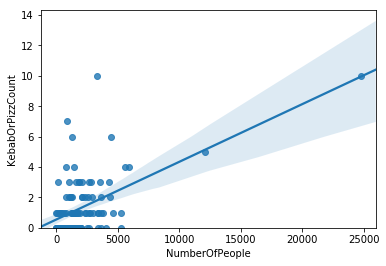

In [70]:
sns.regplot(x="NumberOfPeople", y="KebabOrPizzCount", data=df)
plt.ylim(0,)


Lets calculate the correlation.

In [71]:
df[["NumberOfPeople", "KebabOrPizzCount"]].corr()

NumberOfPeople  KebabOrPizzCount
NumberOfPeople          1.000000          0.555811
KebabOrPizzCount        0.555811          1.000000

The correlation is not so strong. One reason may be that the Tampere borough called Middle has many neigbours with not so many inhabitants. Even though the business life is in the center. Lets see what the result is if we drop the neigbours of the Middle borough.

In [72]:
tmp = df[df['Borough'] != 'Middle']
tmp.head()

Neighborhood       Borough PlanningArea  NumberOfPeople   Latitude  \
0      Aakkula  Northeastern        Messu             481  61.484253   
1    Aitoniemi      Northern         Aito             455  61.567178   
2  Ala-Pispala  Southwestern      Pispala            1097  61.505399   
4        Atala  Northeastern         Tasa            4629  61.503074   
5        Epilä  Southwestern         Raho            1438  61.505720   

   Longitude  Distance  Radius  KebabOrPizzCount  RestaurantCount  
0  23.838243       5.6     370                 0                0  
1  23.822284      23.9    4000                 1                0  
2  23.702884       3.5     600                 2                0  
4  23.908347      10.4    1000                 1                0  
5  23.673316       5.5     780                 1                3

(0, 11.4026899395363)

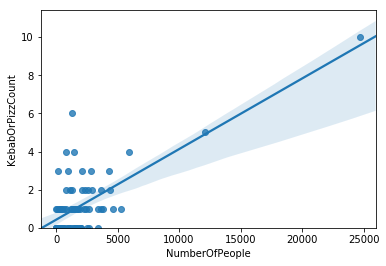

In [73]:
sns.regplot(x="NumberOfPeople", y="KebabOrPizzCount", data=tmp)
plt.ylim(0,)

In [74]:
tmp[["NumberOfPeople", "KebabOrPizzCount"]].corr()

NumberOfPeople  KebabOrPizzCount
NumberOfPeople          1.000000          0.710447
KebabOrPizzCount        0.710447          1.000000

The correlation is now bigger.

##### Lets analyze how the number of people and the number of kebab/pizzeria/fast food places are correlated in boroughs.

In [75]:
# make the groupping.
df_group = df[['Borough','NumberOfPeople', 'KebabOrPizzCount', 'RestaurantCount']]
res = df_group.groupby(['Borough']).sum()

# Lets sort the result.
res_sorted = res.sort_values(by=['NumberOfPeople'], ascending=False)
res_sorted
res_sorted = res_sorted.reset_index()
res_sorted

Borough  NumberOfPeople  KebabOrPizzCount  RestaurantCount
0        Middle           68846                54              123
1  Southeastern           45179                23               11
2  Northeastern           35379                25               12
3  Southwestern           34597                19               15
4      Southern           22377                10                9
5  Northwestern           11743                10                7
6      Northern            4541                 2                7

(0, 59.98692118610091)

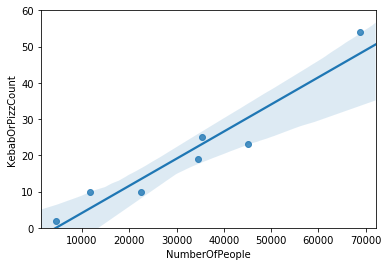

In [76]:
sns.regplot(x="NumberOfPeople", y="KebabOrPizzCount", data=res)
plt.ylim(0,)

In [77]:
# Calculate the regression.
res[["NumberOfPeople", "KebabOrPizzCount"]].corr()

NumberOfPeople  KebabOrPizzCount
NumberOfPeople          1.000000          0.957728
KebabOrPizzCount        0.957728          1.000000

The correlation is very strong. However, as we could see earlier the correlation is not so strong when considering neigbourhoods. 



#### Calculate how many people there are per kebab/pizzeria/fast food place or resraurant.

We have a look at the situation at the borough level at first.

In [78]:
# New columns
res_sorted['PeoplePerKebab'] = res_sorted['NumberOfPeople']/res_sorted['KebabOrPizzCount']
res_sorted['PeoplePerRestaurant'] = res_sorted['NumberOfPeople']/res_sorted['RestaurantCount']
res_sorted

Borough  NumberOfPeople  KebabOrPizzCount  RestaurantCount  \
0        Middle           68846                54              123   
1  Southeastern           45179                23               11   
2  Northeastern           35379                25               12   
3  Southwestern           34597                19               15   
4      Southern           22377                10                9   
5  Northwestern           11743                10                7   
6      Northern            4541                 2                7   

   PeoplePerKebab  PeoplePerRestaurant  
0     1274.925926           559.723577  
1     1964.304348          4107.181818  
2     1415.160000          2948.250000  
3     1820.894737          2306.466667  
4     2237.700000          2486.333333  
5     1174.300000          1677.571429  
6     2270.500000           648.714286

#### We visualize the result.

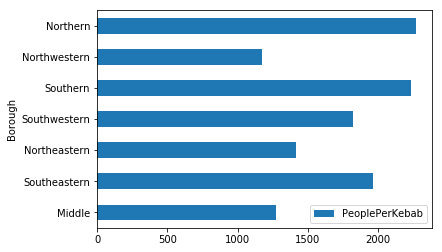

In [79]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

ax = res_sorted.plot.barh(x='Borough', y='PeoplePerKebab')
plt.show()

According to the chart the most promising boroughs could be Northern or Southern boroughs. However, we still have to consider the Middle area as its own, because people from Tampere and all over Finland and also abroad go to the Middle part borough, or at least to some of the neighbours in that borough. Thus the number of inhabitants does not tell the whole truth.

Calculate the total numbers.

In [80]:
# Still calculate the total numbers.
res2 = res_sorted[['NumberOfPeople', 'KebabOrPizzCount']]
res3 = res2.sum()
res3

NumberOfPeople      222662
KebabOrPizzCount       143
dtype: int64

In [138]:
res4 = res_sorted[['NumberOfPeople', 'RestaurantCount']]
res5 = res4.sum()
res5

NumberOfPeople     222662
RestaurantCount       184
dtype: int64

In [81]:
print('{} % of the kebab/pizzeria/fast food places are in the Middle borough'.format(100 * res_sorted.iloc[0,2]/res3['KebabOrPizzCount']))

37.76223776223776 % of the kebab/pizzeria/fast food places are in the Middle borough


We visualize the number of people per other restaurants.

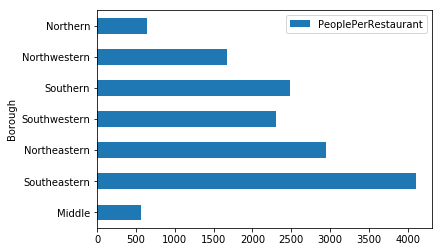

In [82]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

ax = res_sorted.plot.barh(x='Borough', y='PeoplePerRestaurant')
plt.show()

The southern part still seems to be promising, but we can see that there are quite few people per restaurant in Northern borough.

##### Next we calculate how many people there are per kebab/pizzeria/fast food place in each neighbourhood.

In [83]:
df['PeoplePerKebab'] = df['NumberOfPeople']/df['KebabOrPizzCount']
df['PeoplePerRestaurant'] = df['NumberOfPeople']/df['RestaurantCount']
# Sort.
df_sorted = df.sort_values(by=['PeoplePerKebab'], ascending=False)
df_sorted

Neighborhood       Borough PlanningArea  NumberOfPeople   Latitude  \
0          Aakkula  Northeastern        Messu             481  61.484253   
33   Koivistonkylä      Southern     Koivisto            1937  61.472835   
35         Kumpula  Northeastern         Tasa             617  61.511618   
37     Kämmenniemi      Northern       Kämmen            2055  61.627972   
39       Lakalaiva      Southern       Peltoo              37  61.458664   
42           Lappi        Middle        Sampo             784  61.508931   
52        Muotiala        Middle        Iides            1698  61.477114   
53       Myllypuro  Southwestern       Tesoma               4  61.502619   
58         Niihama  Northeastern         Tasa              28  61.516474   
59           Nirva      Southern     Koivisto             434  61.465529   
60           Nurmi      Northern         Aito             359  61.541518   
61           Ojala  Northeastern         Tasa              59  61.516301   
62       Olkahinen  Northeastern         Tasa            1808  61.525562   
63       Osmonmäki        Middle     Keskusta            1712  61.505982   
66         Petsamo        Middle        Sampo            3666  61.507344   
67         Pohtola  Northwestern        Liela            1322  61.536973   
68           Polso      Northern         Terä             170  61.695498   
70        Pyynikki        Middle     Keskusta             756  61.493881   
72     Rantaperkiö      Southern        Härmä            2689  61.473596   
74     Rautaharkko      Southern     Koivisto             615  61.472532   
75       Ristimäki  Southwestern       Tesoma            2031  61.505067   
77         Ruotula  Northeastern        Messu            1529  61.504298   
79     Ryydynpohja  Northwestern        Liela            1421  61.527716   
81      Sarankulma      Southern        Härmä               9  61.457310   
82          Sorila      Northern         Aito             393  61.567944   
85         Tahmela  Southwestern      Pispala             972  61.496671   
89        Tampella        Middle     Keskusta            4058  61.504811   
91       Terälahti      Northern         Terä             464  61.707911   
100        Vihioja        Middle        Iides              53  61.477298   
103     Viitapohja      Northern       Kämmen             245  61.649688   
..             ...           ...          ...             ...        ...   
54         Nalkala        Middle     Keskusta            3546  61.493789   
21       Jokipohja        Middle        Iides            2123  61.478840   
86       Takahuhti  Northeastern        Messu            2122  61.498761   
49       Lukonmäki  Southeastern        Kauka            2838  61.464659   
12        Hatanpää        Middle     Keskusta            2686  61.482560   
56     Niemenranta  Northwestern        Liela             817  61.521144   
26          Kaleva        Middle        Sampo            4491  61.498642   
43         Leinola  Northeastern        Leino            2127  61.485591   
50       Messukylä  Northeastern        Messu             653  61.485298   
57           Niemi  Northwestern      Lentävä            1295  61.528464   
94           Tulli        Middle     Keskusta            1232  61.496894   
88     Tammerkoski        Middle     Keskusta            1829  61.498540   
69   Pyynikinrinne        Middle     Keskusta            1820  61.497270   
2      Ala-Pispala  Southwestern      Pispala            1097  61.505399   
55          Nekala        Middle        Iides            1075  61.483690   
7        Finlayson        Middle     Keskusta            1607  61.501933   
1        Aitoniemi      Northern         Aito             455  61.567178   
95         Turtola  Southeastern        Kauka             836  61.477485   
99        Velaatta      Northern         Terä             400  61.744369   
90         Tasanne  Northeastern         Tasa            1432  61.517894   
84         Taatala      Southern     Koivisto         

We see there exists neighbours with no kebab/pizzeria/fast food places. Lets get them, but before that lets calclate how many people there are per kebab/pizzeria/fast food place in Tampere.

In [84]:
df_apu = df[['NumberOfPeople', 'KebabOrPizzCount']]
summa = df_apu.sum()
print('There are {} people per kebab/pizzeria/fast food place in Tampere'.format(summa['NumberOfPeople']/summa['KebabOrPizzCount']))

There are 1557.076923076923 people per kebab/pizzeria/fast food place in Tampere


In [85]:
# neighbours with no kebab/pizzeria/fast food places:
df_zero = df[df['KebabOrPizzCount'] == 0].reset_index()
df_zero

index   Neighborhood       Borough PlanningArea  NumberOfPeople  \
0       0        Aakkula  Northeastern        Messu             481   
1       3          Amuri        Middle     Keskusta            5311   
2       6    Epilänharju  Southwestern       Tesoma             909   
3       8        Haihara  Southeastern        Kauka             184   
4      13     Haukiluoma  Southwestern       Tesoma            1593   
5      15  Hervantajärvi  Southeastern        Herva              31   
6      16       Holvasti  Northeastern        Leino            2486   
7      17         Huikas  Northeastern        Messu            1058   
8      22     Jussinkylä        Middle     Keskusta            1230   
9      23     Järvensivu        Middle        Sampo            1363   
10     25        Kaarila  Southwestern         Raho            1510   
11     27   Kalevanharju        Middle     Keskusta            1978   
12     28   Kalevanrinne        Middle        Sampo            2000   
13     29         Kalkku  Southwestern         Raho            3382   
14     31         Kauppi        Middle        Sampo              42   
15     33  Koivistonkylä      Southern     Koivisto            1937   
16     34     Korkinmäki      Southern     Koivisto            1103   
17     35        Kumpula  Northeastern         Tasa             617   
18     37    Kämmenniemi      Northern       Kämmen            2055   
19     39      Lakalaiva      Southern       Peltoo              37   
20     42          Lappi        Middle        Sampo             784   
21     52       Muotiala        Middle        Iides            1698   
22     53      Myllypuro  Southwestern       Tesoma               4   
23     58        Niihama  Northeastern         Tasa              28   
24     59          Nirva      Southern     Koivisto             434   
25     60          Nurmi      Northern         Aito             359   
26     61          Ojala  Northeastern         Tasa              59   
27     62      Olkahinen  Northeastern         Tasa            1808   
28     63      Osmonmäki        Middle     Keskusta            1712   
29     66        Petsamo        Middle        Sampo            3666   
30     67        Pohtola  Northwestern        Liela            1322   
31     68          Polso      Northern         Terä             170   
32     70       Pyynikki        Middle     Keskusta             756   
33     72    Rantaperkiö      Southern        Härmä            2689   
34     74    Rautaharkko      Southern     Koivisto             615   
35     75      Ristimäki  Southwestern       Tesoma            2031   
36     77        Ruotula  Northeastern        Messu            1529   
37     79    Ryydynpohja  Northwestern        Liela            1421   
38     81     Sarankulma      Southern        Härmä               9   
39     82         Sorila      Northern         Aito             393   
40     85        Tahmela  Southwestern      Pispala             972   
41     89       Tampella        Middle     Keskusta            4058   
42     91      Terälahti      Northern         Terä             464   
43    100        Vihioja        Middle        Iides              53   
44    103     Viitapohja      Northern       Kämmen             245   
45    105      Vuohenoja        Middle        Sampo             634   
46    107    Ylä-Pispala  Southwestern      Pispala            1706   

     Latitude  Longitude  Distance  Radius  KebabOrPizzCount  RestaurantCount  \
0   61.484253  23.838243      5.60     370                 0                0   
1   61.499639  23.744413      1.00     370                 0                2   
2   61.514067  23.659385      5.10     700                 0                1   
3   61.475935  23.879479      8.30     500                 0                1   
4   61.518774  23.605400      9.70     800                 0                0   
5   61.436032  23.866037     12.50     700                 0                0   
6   61.485825  23.931305    

In [86]:
# Lets order the result by inhabitants.
df_zero_sort = df_zero.sort_values(by=['NumberOfPeople'], ascending=False)
df_zero_sort

index   Neighborhood       Borough PlanningArea  NumberOfPeople  \
1       3          Amuri        Middle     Keskusta            5311   
41     89       Tampella        Middle     Keskusta            4058   
29     66        Petsamo        Middle        Sampo            3666   
13     29         Kalkku  Southwestern         Raho            3382   
33     72    Rantaperkiö      Southern        Härmä            2689   
6      16       Holvasti  Northeastern        Leino            2486   
18     37    Kämmenniemi      Northern       Kämmen            2055   
35     75      Ristimäki  Southwestern       Tesoma            2031   
12     28   Kalevanrinne        Middle        Sampo            2000   
11     27   Kalevanharju        Middle     Keskusta            1978   
15     33  Koivistonkylä      Southern     Koivisto            1937   
27     62      Olkahinen  Northeastern         Tasa            1808   
28     63      Osmonmäki        Middle     Keskusta            1712   
46    107    Ylä-Pispala  Southwestern      Pispala            1706   
21     52       Muotiala        Middle        Iides            1698   
4      13     Haukiluoma  Southwestern       Tesoma            1593   
36     77        Ruotula  Northeastern        Messu            1529   
10     25        Kaarila  Southwestern         Raho            1510   
37     79    Ryydynpohja  Northwestern        Liela            1421   
9      23     Järvensivu        Middle        Sampo            1363   
30     67        Pohtola  Northwestern        Liela            1322   
8      22     Jussinkylä        Middle     Keskusta            1230   
16     34     Korkinmäki      Southern     Koivisto            1103   
7      17         Huikas  Northeastern        Messu            1058   
40     85        Tahmela  Southwestern      Pispala             972   
2       6    Epilänharju  Southwestern       Tesoma             909   
20     42          Lappi        Middle        Sampo             784   
32     70       Pyynikki        Middle     Keskusta             756   
45    105      Vuohenoja        Middle        Sampo             634   
17     35        Kumpula  Northeastern         Tasa             617   
34     74    Rautaharkko      Southern     Koivisto             615   
0       0        Aakkula  Northeastern        Messu             481   
42     91      Terälahti      Northern         Terä             464   
24     59          Nirva      Southern     Koivisto             434   
39     82         Sorila      Northern         Aito             393   
25     60          Nurmi      Northern         Aito             359   
44    103     Viitapohja      Northern       Kämmen             245   
3       8        Haihara  Southeastern        Kauka             184   
31     68          Polso      Northern         Terä             170   
26     61          Ojala  Northeastern         Tasa              59   
43    100        Vihioja        Middle        Iides              53   
14     31         Kauppi        Middle        Sampo              42   
19     39      Lakalaiva      Southern       Peltoo              37   
5      15  Hervantajärvi  Southeastern        Herva              31   
23     58        Niihama  Northeastern         Tasa              28   
38     81     Sarankulma      Southern        Härmä               9   
22     53      Myllypuro  Southwestern       Tesoma               4   

     Latitude  Longitude  Distance  Radius  KebabOrPizzCount  RestaurantCount  \
1   61.499639  23.744413      1.00     370                 0                2   
41  61.504811  23.762547      0.80     500                 0                0   
29  61.507344  23.796602      3.20     700                 0                0   
13  61.497028  23.585739     11.30    1200                 0                0   
33  61.473596  23.753122      4.90    1000                 0                0   
6   61.485825  23.931305     11.20    1000                 0                1   
18  61.627972  23.839381    

In [87]:
# Lets pick those with zero kebab/pizzeria/fast food places and the number of people >= 1600.
df_with_zeros_1600 = df[(df['KebabOrPizzCount'] == 0) & (df['NumberOfPeople'] >= 1600)].reset_index()
# Sort the results by the number of people.
df_with_zeros_1600_sorted = df_with_zeros_1600.sort_values(by=['NumberOfPeople'], ascending=False).reset_index()
df_with_zeros_1600_sorted

level_0  index   Neighborhood       Borough PlanningArea  NumberOfPeople  \
0         0      3          Amuri        Middle     Keskusta            5311   
1        13     89       Tampella        Middle     Keskusta            4058   
2        10     66        Petsamo        Middle        Sampo            3666   
3         4     29         Kalkku  Southwestern         Raho            3382   
4        11     72    Rantaperkiö      Southern        Härmä            2689   
5         1     16       Holvasti  Northeastern        Leino            2486   
6         6     37    Kämmenniemi      Northern       Kämmen            2055   
7        12     75      Ristimäki  Southwestern       Tesoma            2031   
8         3     28   Kalevanrinne        Middle        Sampo            2000   
9         2     27   Kalevanharju        Middle     Keskusta            1978   
10        5     33  Koivistonkylä      Southern     Koivisto            1937   
11        8     62      Olkahinen  Northeastern         Tasa            1808   
12        9     63      Osmonmäki        Middle     Keskusta            1712   
13       14    107    Ylä-Pispala  Southwestern      Pispala            1706   
14        7     52       Muotiala        Middle        Iides            1698   

     Latitude  Longitude  Distance  Radius  KebabOrPizzCount  RestaurantCount  \
0   61.499639  23.744413       1.0     370                 0                2   
1   61.504811  23.762547       0.8     500                 0                0   
2   61.507344  23.796602       3.2     700                 0                0   
3   61.497028  23.585739      11.3    1200                 0                0   
4   61.473596  23.753122       4.9    1000                 0                0   
5   61.485825  23.931305      11.2    1000                 0                1   
6   61.627972  23.839381      27.3    5000                 0                1   
7   61.505067  23.642134       7.9     800                 0                0   
8   61.493415  23.808961       2.7     500                 0                3   
9   61.492486  23.783433       1.5     600                 0                0   
10  61.472835  23.789159       5.6     800                 0                3   
11  61.525562  23.942418      13.1     950                 0                0   
12  61.505982  23.778676       1.4     400                 0                0   
13  61.501747  23.714986       2.8     600                 0                1   
14  61.477114  23.823014       5.5     700                 0                0   

    PeoplePerKebab  PeoplePerRestaurant  
0              inf          2655.500000  
1              inf                  inf  
2              inf                  inf  
3              inf                  inf  
4              inf                  inf  
5              inf          2486.000000  
6              inf          2055.000000  
7              inf                  inf  
8              inf           666.666667  
9              inf                  inf  
10             inf           645.666667  
11             inf                  inf  
12             inf                  inf  
13             inf          1706.000000  
14             inf                  inf

When looking at the results above we can see Tampella might be a good choise. However, it is so close to the center that in the neighbouhoods around there are plenty of competitors, as we will see later when investigating the Tampere center area. So we have to consider that, too.
Kalkku in Southwestern area is far from the center, and is a good candidate. One good choise is also Kämmenniemi, because it is far from Tampere center (over 27 kilometers, and there is only one other type restaurant there. We looked that in Tampere there are about 1500 people per one kebab/pizzeria/fast food place. Thus most of the areas above can be considered.

We look at the numbers where there exist at least one fast food place.

In [89]:
# neighbours with no kebab/pizzeria/fast food places:
df_not_zero = df[df['KebabOrPizzCount'] != 0].reset_index()
df_not_zero = df_not_zero.sort_values(by=['PeoplePerKebab'], ascending=False)
df_not_zero.head(10)

index  Neighborhood       Borough PlanningArea  NumberOfPeople   Latitude  \
11     19       Härmälä      Southern        Härmä            5259  61.470583   
2       4         Atala  Northeastern         Tasa            4629  61.503074   
38     71        Rahola  Southwestern         Raho            3807  61.498364   
35     64       Pappila  Northeastern        Messu            3617  61.490865   
36     65    Peltolammi      Southern       Peltoo            3427  61.453009   
25     46  Liisankallio        Middle        Sampo            3396  61.499121   
14     24     Kaakinmaa        Middle     Keskusta            2983  61.493447   
17     32     Kissanmaa        Middle        Sampo            2752  61.500139   
6      10       Hallila  Southeastern        Kauka            2685  61.464759   
9      14      Hervanta  Southeastern        Herva           24738  61.450903   

    Longitude  Distance  Radius  KebabOrPizzCount  RestaurantCount  \
11  23.739260       5.6    1200                 1                1   
2   23.908347      10.4    1000                 1                0   
38  23.631977       8.3    1000                 1                1   
35  23.863134       7.5    1000                 1                0   
36  23.754549       7.0    1000                 1                0   
25  23.791252       1.8     500                 1                3   
14  23.750052       1.1     370                 1                6   
17  23.819561       3.3     600                 1                0   
6   23.829035       8.2     750                 1                0   
9   23.851424      10.4    1500                10                8   

    PeoplePerKebab  PeoplePerRestaurant  
11          5259.0          5259.000000  
2           4629.0                  inf  
38          3807.0          3807.000000  
35          3617.0                  inf  
36          3427.0                  inf  
25          3396.0          1132.000000  
14          2983.0           497.166667  
17          2752.0                  inf  
6           2685.0                  inf  
9           2473.8          3092.250000

We can see that clearly Amuri and Härmälä are promising places. However, Amuri is just near the center, so we should consider its position among the other center neihgbouhoods.

### The amount of kebab/pizzeria/fast food places versus other restaurants and Tampere center area

Next we look the amount of kebab/pizzeria/fast food places versus other restaurants.

In [90]:
kebab_or_pizz_count = df['KebabOrPizzCount'].sum()
other_restaurants_count = df['RestaurantCount'].sum()
percentage = 100 * kebab_or_pizz_count /(kebab_or_pizz_count + other_restaurants_count)
print('In Tampere there are {} kebab/pizzeria/fast food places'.format(kebab_or_pizz_count))
print('In Tampere there are {} other restaurants (not kebab/pizzeria/fast food places)'.format(other_restaurants_count))
print('Thus {} % of the food places are kebab/pizzeria/fast food places)'.format(percentage))

In Tampere there are 143 kebab/pizzeria/fast food places
In Tampere there are 184 other restaurants (not kebab/pizzeria/fast food places)
Thus 43.730886850152906 % of the food places are kebab/pizzeria/fast food places)


In [91]:
# From the earlier dataframes we can count:
print('{} % of the kebab/pizzeria/fast food places are in the Middle borough.'.format(100 * res_sorted.iloc[0,2]/res3['KebabOrPizzCount']))

37.76223776223776 % of the kebab/pizzeria/fast food places are in the Middle borough.


In [92]:
print('{} % of the food places in the Middle borough are kebab/pizzeria/fast food places'.format(100 * res_sorted.iloc[0,2]/res_sorted.iloc[0,3]))

43.90243902439025 % of the food places in the Middle borough are kebab/pizzeria/fast food places


Thus we can see that kebab/pizzeria/fast food places are quite common, and popular in Tampere. From the map earlier we could also see that there are many kebab/pizzeria/fast food places and other restaurants in Tampere center, whitch is quite obvious. Lets now count the number of kebab/pizzeria/fast food places and other restaurants 1 km around Tampere center (Keskustori).

In [93]:
# Let's get nearby kebab/pizzeria/fast food places, and on the other hand other restaurants.
def getNearbyVenues2(latitude, longitude, radius, category):
    LIMIT = 2000
    
    venues_list=[]
    venues = get_venues_near_location(latitude, longitude, food_category, CLIENT_ID, 
                                      CLIENT_SECRET, radius=radius, limit=1000 )
    for venue in venues:
        venue_id = venue[0]
        venue_name = venue[1]
        venue_categories = venue[2]
        venue_latlon = venue[3]
        venue_address = venue[4]
        venue_distance = venue[5]
        venue_categoryname = venue[6]
        is_res, is_kebab_or_pizz = is_kebab_or_pizzeria_f(venue_categories, specific_filter=kebab_restaurant_categories)
        #print(venue_categories)
        
        if ((is_kebab_or_pizz or is_res)):
            venues_list.append([(
                                venue_name,
                                venue_categoryname,
                                venue_address,
                                venue_latlon[0],
                                venue_latlon[1],
                                venue_distance,
                                is_kebab_or_pizz,
                                is_res, 
                                venue_id)])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Venue', 
                             'Venue Category',
                             'Venue Address',
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Distance',
                             'KebabOrPizzeria',
                             'Restaurant',
                             'Venue Id']
    
    return(nearby_venues)

In [94]:
# Get the venues.
tampere_center_venues = getNearbyVenues2(tampere_lat,
                                         tampere_lon,
                                         1000,
                                         category = food_category)

In [95]:
tampere_center_venues

Venue                 Venue Category  \
0                          4 Vuodenaikaa              French Restaurant   
1                        Ravinteli Huber                     Steakhouse   
2                             Cafe Gopal  Vegetarian / Vegan Restaurant   
3                             Maka Sushi               Sushi Restaurant   
4                                  Umami               Sushi Restaurant   
5                        Friends & Brgrs                   Burger Joint   
6                          Pyörykkäbaari           Fast Food Restaurant   
7                      Thai Golden Chang                Thai Restaurant   
8             Pizzeria Napoli Ristorante                    Pizza Place   
9                                   Inez               Tapas Restaurant   
10                     Sitko Pizza & Bar                    Pizza Place   
11                              Katmandu        North Indian Restaurant   
12                          Naughty BRGR                   Burger Joint   
13                         Pizzeria Luca                    Pizza Place   
14                              PureBite                     Restaurant   
15                  Ravintola Tiiliholvi        Scandinavian Restaurant   
16                   Stefan's Steakhouse                     Steakhouse   
17                  Saunaravintola Kuuma                     Restaurant   
18                              Maruseki            Japanese Restaurant   
19                   Finlaysonin Palatsi                     Restaurant   
20          Indian Restaurant Nanda Devi              Indian Restaurant   
21                                Faasai                Thai Restaurant   
22                              Itsudemo               Sushi Restaurant   
23                              Katmandu        North Indian Restaurant   
24                      Ravinteli Bertha        Scandinavian Restaurant   
25                       Pizzeria Bianco                    Pizza Place   
26                        Baba's Kitchen               Kebab Restaurant   
27                               Zeytuun      Middle Eastern Restaurant   
28                 Vinoteca del Piemonte             Italian Restaurant   
29                                 Muusa                     Restaurant   
..                                   ...                            ...   
36                           Tom & Crill                     Restaurant   
37                     Edun Herkkukeidas                     Restaurant   
38                             Delisushi               Sushi Restaurant   
39                   Nittaya Thai & Laos               Asian Restaurant   
40                      Pizzeria La Gare                    Pizza Place   
41            Grillsson Steakhouse & Bar                     Steakhouse   
42                               Zipatta        Scandinavian Restaurant   
43           Burger King Tampere, Ratina           Fast Food Restaurant   
44                          Bengol Curry              Indian Restaurant   
45                          Zhou's place             Chinese Restaurant   
46                             Grill it!                     Steakhouse   
47                         Söpö Himalaya           Himalayan Restaurant   
48                            Chopsticks               Asian Restaurant   
49                              La Toore                    Pizza Place   
50                                Tratto             Italian Restaurant   
51            Tuulihattu Lounasravintola                          Diner   
52                    Ravintola Myllärit        Scandinavian Restaurant   
53                           Lähiruokala        Scandinavian Restaurant   
54           Coriander Indian Restaurant              Indian Restaurant   
55                         Ravintola Pyy        Scandinavian Restaurant   
56                        Ravintola Piha        Scandinavian Restaurant   
57               Cafe Aleksanterinpuisto                    

In [96]:
# See how many are in the center.
temp = tampere_center_venues['KebabOrPizzeria']
temp.value_counts()

False    54
True     12
Name: KebabOrPizzeria, dtype: int64

Thus we can see that only under 20 % of all the restaurants are kebab places/pizzerias/fast food places 1 km around Tampere center. Thus in Tampere center there are many normal or special type restaurants. On the other hand in the Middle borough over 43 % of the restaurants are kebab places/pizzerias/fast food places.

Lets still visualize the venues on the map.

In [97]:
address = 'Tampere, Finland'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
lat = location.latitude
lng = location.longitude

map_tampere = folium.Map(location=[lat, lng], zoom_start=13)

for lat, lng, label, is_kebab_or_pizzeria, ven_address in zip(tampere_center_venues['Venue Latitude'], tampere_center_venues['Venue Longitude'], 
                           tampere_center_venues['Venue'], tampere_center_venues['KebabOrPizzeria'], tampere_center_venues['Venue Address']):
    label = label + ", " + ven_address
    label = folium.Popup(label, parse_html=True)
    color = 'red' if is_kebab_or_pizzeria else 'blue'
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color=color,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=1,
        parse_html=False).add_to(map_tampere)  

map_tampere









### Looking the amount of shops and bars around kebab/pizzeria/fast food places.

In [98]:
tampere_venues.head()

Neighborhood       Borough  NumberOfPeople  Neighborhood Latitude  \
0    Aitoniemi      Northern             455              61.567178   
1  Ala-Pispala  Southwestern            1097              61.505399   
2  Ala-Pispala  Southwestern            1097              61.505399   
3        Amuri        Middle            5311              61.499639   
4        Amuri        Middle            5311              61.499639   

   Neighborhood Longitude                                 Venue  \
0               23.822284              Eevalandian Grillikestit   
1               23.702884                               Pizpala   
2               23.702884                             Kotipizza   
3               23.744413               Cafe Aleksanterinpuisto   
4               23.744413  Tu Huong (Pyynikintorin kiinalainen)   

         Venue Category                         Venue Address  Venue Latitude  \
0  Fast Food Restaurant                     Aitoniementie 820       61.569017   
1           Pizza Place   Pispalan valtatie 28, 33250 Tampere       61.506290   
2           Pizza Place  Pispalanvaltatie 73 B, 33250 Tampere       61.506044   
3            Restaurant        Puutarhakatu 37, 33230 Tampere       61.498185   
4    Chinese Restaurant                Puutarhakatu 39, 33230       61.497927   

   Venue Longitude  Venue Distance  KebabOrPizzeria  Restaurant  \
0        23.830893             500             True       False   
1        23.700379             165             True       False   
2        23.699384             199             True       False   
3        23.744745             162            False        True   
4        23.742659             212            False        True   

                   Venue Id  ShopCount  BarCount  fast_food_competitor_count  \
0  5012a930e4b037378c45f6cd          0         0                           0   
1  4b5e24c3f964a520108029e3          3         3                           4   
2  4be6a2332468c9283e8b0143          3         3                           4   
3  547ee5cb498e6d9fc5f03485         63        24                          13   
4  4bc1dce14cdfc9b6061f9521         63        19                          13   

   restaurant_competitor_count  
0                            0  
1                            2  
2                            2  
3                           24  
4                           23

Next we sort the food places according to the number on shops 100 meters around the place.

In [100]:
tre_venues = tampere_venues[['Neighborhood','Borough','Venue', 'Venue Category', 'KebabOrPizzeria', 'Restaurant', 'ShopCount', 'BarCount',
                             'fast_food_competitor_count','restaurant_competitor_count']]
tampere_venues_sort_by_shops = tre_venues.sort_values(by=['ShopCount'], ascending=False)
tampere_venues_sort_by_shops = tampere_venues_sort_by_shops
tampere_venues_sort_by_shops

Neighborhood       Borough                                  Venue  \
16       Finlayson        Middle                                    Taj   
15       Finlayson        Middle                 Classic American Diner   
19       Finlayson        Middle                              Bocadillo   
210         Ratina        Middle                    Stefan's Steakhouse   
18       Finlayson        Middle                            Bravo Plaza   
268    Tammerkoski        Middle                             Cafe Gopal   
272    Tammerkoski        Middle                        Friends & Brgrs   
118        Kyttälä        Middle                                 Puisto   
275    Tammerkoski        Middle                      Sitko Pizza & Bar   
66      Jussinkylä        Middle                                  Muusa   
68      Jussinkylä        Middle              Trattoria Tammerin puisto   
111        Kyttälä        Middle                        Pizzeria Bianco   
127        Kyttälä        Middle                                Zipatta   
271    Tammerkoski        Middle                                  Umami   
273    Tammerkoski        Middle                          Pyörykkäbaari   
188        Nalkala        Middle                     Kauppuri 5 Tampere   
187        Nalkala        Middle                           Punjab Kebab   
69      Jussinkylä        Middle                     Ravintola Tampella   
70       Kaakinmaa        Middle                                  Drina   
109        Kyttälä        Middle                                Zeytuun   
107        Kyttälä        Middle                          Pizzeria Luca   
71       Kaakinmaa        Middle                          Ravintola Pyy   
213         Ratina        Middle                    Nittaya Thai & Laos   
110        Kyttälä        Middle                           Bodega Salud   
183        Nalkala        Middle                                Henriks   
180        Nalkala        Middle                          Ravintola LEO   
276    Tammerkoski        Middle                   Ravintola Tiiliholvi   
277    Tammerkoski        Middle                               Maruseki   
116        Kyttälä        Middle                                Zarillo   
115        Kyttälä        Middle         Pikkukiinalainen Nguyen Cao Su   
..             ...           ...                                    ...   
27         Hallila  Southeastern                      Hallilan pizzeria   
154  Lentävänniemi  Northwestern                   pizzeria le tuomiset   
9            Epilä  Southwestern                      Kokkailen Ellalle   
63           Ikuri  Southwestern                        Pizzeria Domine   
231          Rusko  Southeastern                            KiitoKöökki   
53        Hervanta  Southeastern               Lounasravintola Hyrysysy   
250        Tahmela  Southwestern                         Ravintola Säde   
253      Takahuhti  Northeastern                     Ruoko Suon Keittiö   
280        Tasanne  Northeastern                            Lazio Pizza   
145        Leinola  Northeastern                          liinun grilli   
192          Niemi  Northwestern                            TPA Ruokala   
279        Tasanne  Northeastern                              Kike Böst   
138    Lahdesjärvi      Southern                              Hesburger   
278        Tasanne  Northeastern                       Pizzeria Tasanne   
175     Multisilta      Southern                          mimon ruokala   
153  Lentävänniemi  Northwestern                Lennie Kebab / Pizzeria   
198        Pohtola  Northwestern                            kaisan koti   
152  Lentävänniemi  Northwestern                     Tanen Lihotusluola   
193          Niemi  Northwestern                              Kotipizza   
236         Sorila      Northern                     TP:n kokkinurkkaus   
321     Viitapohja      Northern                      Isosaaren ruokala   
201          Polso      Norther

We can see that the food places in neighbourhoods in Middle borough near Tampere center has lots of shops around. Allmost all the food places have shop (or at least bar) in the vicinity.

Lets order the venues by bar count in the near vicinity.


In [102]:
tre_venues = tampere_venues[['Neighborhood', 'Borough', 'Venue', 'Venue Category', 'KebabOrPizzeria', 'Restaurant', 'ShopCount', 'BarCount',
                             'fast_food_competitor_count','restaurant_competitor_count']]
tampere_venues_sort_by_bars = tre_venues.sort_values(by=['BarCount'], ascending=False)
tampere_venues_sort_by_bars = tampere_venues_sort_by_bars
tampere_venues_sort_by_bars

Neighborhood       Borough                                  Venue  \
294        Tulli        Middle                                  Sasor   
223       Ratina        Middle                       Tiinan kotiruoka   
263      Tammela        Middle                   Tammelantorin Burger   
132      Kyttälä        Middle               Yitong Hotpot Restaurant   
128      Kyttälä        Middle                            Burger King   
123      Kyttälä        Middle                           Pancho Villa   
120      Kyttälä        Middle                                 Fafa's   
119      Kyttälä        Middle                    MASU - Asian Bistro   
110      Kyttälä        Middle                           Bodega Salud   
104      Kyttälä        Middle                           Naughty BRGR   
130      Kyttälä        Middle                           Lotus Garden   
135      Kyttälä        Middle     Lankarullakioski aka "Rautagrilli"   
134      Kyttälä        Middle                    Roka Sushi & Robata   
133      Kyttälä        Middle                                 Lie Mi   
113      Kyttälä        Middle                            Ravintola C   
105      Kyttälä        Middle                                   Inez   
107      Kyttälä        Middle                          Pizzeria Luca   
256      Tammela        Middle                              Kalakokit   
114      Kyttälä        Middle                                 Faasai   
115      Kyttälä        Middle         Pikkukiinalainen Nguyen Cao Su   
121      Kyttälä        Middle                              Kotipizza   
124      Kyttälä        Middle                               Midway's   
112      Kyttälä        Middle                               Katmandu   
129      Kyttälä        Middle                          Suleima Kebab   
215       Ratina        Middle                              Delisushi   
117      Kyttälä        Middle               Dining 26 by Arto Rastas   
20     Finlayson        Middle                                 Purpur   
136      Kyttälä        Middle                            Aloha Ramen   
16     Finlayson        Middle                                    Taj   
103      Kyttälä        Middle             Pizzeria Napoli Ristorante   
..           ...           ...                                    ...   
149      Leinola  Northeastern                                Mummula   
150      Leinola  Northeastern                               jannella   
157     Lielahti  Northwestern                             McDonald's   
199        Polso      Northern  Juhlaravintola & Country Bistro Maisa   
142    Lamminpää  Southwestern                                  Helmi   
141    Lamminpää  Southwestern                             Ylä-Grilli   
232  Ryydynpohja  Northwestern                     Kapitonas Morganas   
236       Sorila      Northern                     TP:n kokkinurkkaus   
201        Polso      Northern          Ruoka- & Juhlaravintola Maisa   
59         Ikuri  Southwestern                  Mummin herkkupöydässä   
200        Polso      Northern           Maisansalon Kartanoravintola   
310    Vehmainen  Northeastern          Vehmaisten Pizzeria-Ravintola   
198      Pohtola  Northwestern                            kaisan koti   
250      Tahmela  Southwestern                         Ravintola Säde   
95    Kaukajärvi  Southeastern                         Annalan Kioski   
305      Turtola  Southeastern                              Kotipizza   
304      Turtola  Southeastern                              Hesburger   
325       Vuores      Southern           Vuoreksen Ravintola Pizzeria   
148      Leinola  Northeastern                  Helin Lumoava Keittiö   
156     Lielahti  Northwestern                 Classic American Diner   
321   Viitapohja      Northern                      Isosaaren ruokala   
137  Kämmenniemi      Northern            Kämmenniemen koulun ruokala   
147      Leinola  Northeastern               Hebun - Pizzeria 

The food places in the Middle neighbourhoods are rounded by many bars. 

## Clustering the data

We cluster the venues in order to see an overall picture of the kebab/pizzeria/fast food and other restaurants. Before that we select the suitable columns, and normalize the table.

Run k-means to cluster the neighborhood into 5 clusters.

In [103]:
df.columns

Index(['Neighborhood', 'Borough', 'PlanningArea', 'NumberOfPeople', 'Latitude',
       'Longitude', 'Distance', 'Radius', 'KebabOrPizzCount',
       'RestaurantCount', 'PeoplePerKebab', 'PeoplePerRestaurant'],
      dtype='object')

In [165]:
#fast_food_venues = tampere_venues[tampere_venues['KebabOrPizzeria'] == True]

#fast_food_venues.shape

(143, 19)

In [104]:
tampere_venues.columns


Index(['Neighborhood', 'Borough', 'NumberOfPeople', 'Neighborhood Latitude',
       'Neighborhood Longitude', 'Venue', 'Venue Category', 'Venue Address',
       'Venue Latitude', 'Venue Longitude', 'Venue Distance',
       'KebabOrPizzeria', 'Restaurant', 'Venue Id', 'ShopCount', 'BarCount',
       'fast_food_competitor_count', 'restaurant_competitor_count'],
      dtype='object')

In [105]:
# set number of clusters
kclusters = 5

tre_cluster_venues = tampere_venues[['Venue Id', 'Neighborhood', 'ShopCount', 'BarCount', 'fast_food_competitor_count','restaurant_competitor_count']]
tre_cluster_venues['NumberOfPeople'] = 0
tre_cluster_venues['Distance'] = 0
tre_cluster_venues['NumberOfPeople'] = tre_cluster_venues['NumberOfPeople'].astype(int)
tre_cluster_venues['Distance'] = tre_cluster_venues['Distance'].astype(float)

i = 0
for index, row in tre_cluster_venues.iterrows():
    neighbourhood = row['Neighborhood']
    venue_id = row['Venue Id']
    
    ind = df[df['Neighborhood'] == neighbourhood].index
    
    inhabitants = df.get_value(ind, 3, takeable = True)
    distance = df.get_value(ind, 6, takeable = True) 
    
    # Update the data
    tre_cluster_venues.iloc[i, 6] = inhabitants[0]
    tre_cluster_venues.iloc[i, 7] = distance[0]
    i = i + 1


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/

In [106]:
tre_cluster_venues

Venue Id Neighborhood  ShopCount  BarCount  \
0    5012a930e4b037378c45f6cd    Aitoniemi          0         0   
1    4b5e24c3f964a520108029e3  Ala-Pispala          3         3   
2    4be6a2332468c9283e8b0143  Ala-Pispala          3         3   
3    547ee5cb498e6d9fc5f03485        Amuri         63        24   
4    4bc1dce14cdfc9b6061f9521        Amuri         63        19   
5    4f31458de4b0d77c27e284b1        Atala         13         3   
6    4dc6a173d22dafda2fc1b36a        Epilä         21         2   
7    4c950856533aa0936e18c545        Epilä         21         3   
8    4f4cef2be4b0629e79e2c482        Epilä          9         3   
9    4f142340e4b0aabf1a67eab5        Epilä          2         2   
10   56cec7cacd10c5a62aa11363  Epilänharju         39         0   
11   4c54119606901b8d9ccf2c4b    Finlayson         83        40   
12   4be2d49b1dd22d7f44e694bd    Finlayson         84        39   
13   4b6942baf964a520279d2be3    Finlayson         84        42   
14   4b597698f964a520108928e3    Finlayson         84        43   
15   4b543132f964a52037b427e3    Finlayson         86        48   
16   53105baf498e43d4c49e0a0b    Finlayson         86        49   
17   4d2f1ccfe04354814058b6ed    Finlayson         84        44   
18   4b61d76df964a52059262ae3    Finlayson         85        44   
19   4bc2f20bb492d13aa210a860    Finlayson         86        47   
20   59fde12ef8cbd4399d554a4c    Finlayson         84        49   
21   4bacdc34f964a520dd123be3    Finlayson         84        42   
22   54253022498e5a95dd6d0904      Haihara          5         5   
23   4bade46ef964a5206a703be3    Hakametsä         23         4   
24   5399a1df498e718f898f7adc    Hakametsä         23         4   
25   5730d286498e0ee5fd0aec56    Hakametsä         23         5   
26   505976f164a46051cba9b769    Hakametsä         23         5   
27   4c8b8af51eafb1f70a6b8435      Hallila          2         2   
28   4b7fde6ef964a520a54130e3      Hankkio          5         5   
29   4df08c8dfa76042fed6eb6f9     Hatanpää          3         3   
..                        ...          ...        ...       ...   
297  5220824611d21cc07130421a        Tulli         78        43   
298  50dd968de4b0d90b0f5fe042        Tulli         77        41   
299  544135da498e6fee78961443        Tulli         79        40   
300  5629faa3498edb1ed82721ba        Tulli         77        43   
301  561d305e498e1a672921740d        Tulli         80        37   
302  4b5eae46f964a520b99529e3        Tulli         80        39   
303  4c66c1f27abde21e104a6468        Tulli         79        41   
304  4c1ca2dbb4e62d7fa558db93      Turtola         10         1   
305  4c0e239298102d7fb61de306      Turtola         10         1   
306  510f7853011ce960937d378d     Uusikylä         24         4   
307  510f7a7d011ce9609380ee0c     Uusikylä         24         4   
308  510f79b7011ce960937fafad     Uusikylä         24         4   
309  4c828948d4e237046b646888     Uusikylä         21         3   
310  4b61cdd9f964a520e3232ae3    Vehmainen          3         1   
311  4eb6aa8b93ad236570ad34ff        Veisu          0         0   
312  4fafa998e4b09cca61fa0269        Veisu          0         0   
313  4fe5b557e4b043cb4b457d9a     Velaatta          0         0   
314  50816f51e4b068d89b92a1af     Velaatta          0         0   
315  4cdd1381fc973704d87cd905      Vihioja          9         3   
316  54e3166f498e2dc6fb48012f      Vihioja          9         4   
317  4ed7bb445c5ce1cd63976c3f       Viiala         10         3   
318  4e9eadc7775b7e725b72283a     Viinikka          9         4   
319  4cf629ed64e3721e12851fc8     Viinikka          8         2   
320  4b879175f964a52023c331e3     Viinikka          9         4   
321  5002cc41e4b031e9cb7ef6ba   Viitapohja          0         0   
322  5112758be4b0b2cd38725908      Villilä          3         3   
323  4f4cc1c9e4b0774b558f13dc      Villilä          6         5   
324  4fae3bd2e4b06952df67dd4d    Vuohenoja         16         4   
3

In [107]:
# Pick up the numerical values.
tre_cluster_venues = tre_cluster_venues[['ShopCount', 'BarCount', 'fast_food_competitor_count','restaurant_competitor_count', 
                                         'NumberOfPeople', 'Distance']]                                       
#tre_cluster_venues.drop(['B', 'C'], axis=1)
tre_cluster_venues.head()                                       

ShopCount  BarCount  fast_food_competitor_count  \
0          0         0                           0   
1          3         3                           4   
2          3         3                           4   
3         63        24                          13   
4         63        19                          13   

   restaurant_competitor_count  NumberOfPeople  Distance  
0                            0             455      23.9  
1                            2            1097       3.5  
2                            2            1097       3.5  
3                           24            5311       1.0  
4                           23            5311       1.0

##### Normalize the data

In [108]:
from sklearn.preprocessing import StandardScaler
X = tre_cluster_venues.values[:,1:]
#X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet


array([[-0.9599205 , -1.467476  , -0.98692487, -0.59746356,  3.13855398],
       [-0.80925138, -0.7370884 , -0.88779281, -0.47993905, -0.25579207],
       [-0.80925138, -0.7370884 , -0.88779281, -0.47993905, -0.25579207],
       ...,
       [-0.75902834, -0.1892977 , -0.98692487, -0.56469582, -0.13931941],
       [-0.9599205 , -1.467476  , -0.98692487, -0.324155  ,  0.95885137],
       [-0.80925138, -0.9196853 , -0.88779281, -0.36845552, -0.37226473]])

In [109]:
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Clus_dataSet)

In [110]:

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([4, 2, 2, 0, 0, 2, 2, 2, 2, 2], dtype=int32)

In [111]:
tampere_venues.head()

Neighborhood       Borough  NumberOfPeople  Neighborhood Latitude  \
0    Aitoniemi      Northern             455              61.567178   
1  Ala-Pispala  Southwestern            1097              61.505399   
2  Ala-Pispala  Southwestern            1097              61.505399   
3        Amuri        Middle            5311              61.499639   
4        Amuri        Middle            5311              61.499639   

   Neighborhood Longitude                                 Venue  \
0               23.822284              Eevalandian Grillikestit   
1               23.702884                               Pizpala   
2               23.702884                             Kotipizza   
3               23.744413               Cafe Aleksanterinpuisto   
4               23.744413  Tu Huong (Pyynikintorin kiinalainen)   

         Venue Category                         Venue Address  Venue Latitude  \
0  Fast Food Restaurant                     Aitoniementie 820       61.569017   
1           Pizza Place   Pispalan valtatie 28, 33250 Tampere       61.506290   
2           Pizza Place  Pispalanvaltatie 73 B, 33250 Tampere       61.506044   
3            Restaurant        Puutarhakatu 37, 33230 Tampere       61.498185   
4    Chinese Restaurant                Puutarhakatu 39, 33230       61.497927   

   Venue Longitude  Venue Distance  KebabOrPizzeria  Restaurant  \
0        23.830893             500             True       False   
1        23.700379             165             True       False   
2        23.699384             199             True       False   
3        23.744745             162            False        True   
4        23.742659             212            False        True   

                   Venue Id  ShopCount  BarCount  fast_food_competitor_count  \
0  5012a930e4b037378c45f6cd          0         0                           0   
1  4b5e24c3f964a520108029e3          3         3                           4   
2  4be6a2332468c9283e8b0143          3         3                           4   
3  547ee5cb498e6d9fc5f03485         63        24                          13   
4  4bc1dce14cdfc9b6061f9521         63        19                          13   

   restaurant_competitor_count  
0                            0  
1                            2  
2                            2  
3                           24  
4                           23

In [112]:
# add clustering labels
tampere_venues.insert(0, 'Cluster Labels', kmeans.labels_)


In [113]:
tampere_venues.head()

Cluster Labels Neighborhood       Borough  NumberOfPeople  \
0               4    Aitoniemi      Northern             455   
1               2  Ala-Pispala  Southwestern            1097   
2               2  Ala-Pispala  Southwestern            1097   
3               0        Amuri        Middle            5311   
4               0        Amuri        Middle            5311   

   Neighborhood Latitude  Neighborhood Longitude  \
0              61.567178               23.822284   
1              61.505399               23.702884   
2              61.505399               23.702884   
3              61.499639               23.744413   
4              61.499639               23.744413   

                                  Venue        Venue Category  \
0              Eevalandian Grillikestit  Fast Food Restaurant   
1                               Pizpala           Pizza Place   
2                             Kotipizza           Pizza Place   
3               Cafe Aleksanterinpuisto            Restaurant   
4  Tu Huong (Pyynikintorin kiinalainen)    Chinese Restaurant   

                          Venue Address  Venue Latitude  Venue Longitude  \
0                     Aitoniementie 820       61.569017        23.830893   
1   Pispalan valtatie 28, 33250 Tampere       61.506290        23.700379   
2  Pispalanvaltatie 73 B, 33250 Tampere       61.506044        23.699384   
3        Puutarhakatu 37, 33230 Tampere       61.498185        23.744745   
4                Puutarhakatu 39, 33230       61.497927        23.742659   

   Venue Distance  KebabOrPizzeria  Restaurant                  Venue Id  \
0             500             True       False  5012a930e4b037378c45f6cd   
1             165             True       False  4b5e24c3f964a520108029e3   
2             199             True       False  4be6a2332468c9283e8b0143   
3             162            False        True  547ee5cb498e6d9fc5f03485   
4             212            False        True  4bc1dce14cdfc9b6061f9521   

   ShopCount  BarCount  fast_food_competitor_count  \
0          0         0                           0   
1          3         3                           4   
2          3         3                           4   
3         63        24                          13   
4         63        19                          13   

   restaurant_competitor_count  
0                            0  
1                            2  
2                            2  
3                           24  
4                           23

##### Let's visualize the resulting clusters.

In [114]:
address = 'Tampere, Finland'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
lat = location.latitude
lng = location.longitude

map_tampere = folium.Map(location=[lat, lng], zoom_start=13)

for lat, lng, label, is_kebab_or_pizzeria, ven_address, cluster in zip(tampere_venues['Venue Latitude'], tampere_venues['Venue Longitude'], 
                           tampere_venues['Venue'], tampere_venues['KebabOrPizzeria'], tampere_venues['Venue Address'], 
                           tampere_venues['Cluster Labels']):
    label = str(cluster) + ": " + label + ", " + ven_address
    label = folium.Popup(label, parse_html=True)
    
    if (cluster == 0):
        color = 'red'
    elif (cluster == 1):
        color = 'blue'
    elif (cluster == 2):
        color = 'green'
    elif (cluster == 3):
        color = 'yellow'
    elif (cluster == 4):
        color = 'grey'
    else:
        color = 'black'
        
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color=color,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=1,
        parse_html=False).add_to(map_tampere)  

map_tampere









There are clearly different types:
1. The restaurants in the center.
2. The restaurant just a little bit further from the center.
3. Restaurants in neigbourhoods not in the center.
4. Restaurants in Hervanta which is not in the center but is very populated.
5. Restaurants very far from the center in landscape area.

We could analyze those areas further, but now pick up the neigbourhoods where there are zero kebab/pizzeria/fast food places and those neihgbourhoods where there are many people per zero kebab/pizzeria/fast food place. From these we pick up only Härmälä.

Then we make a choice to investigate only the neigbourhoods not right in the center (3 kms far from center).

In [115]:
# List the neigbourhoods with zero kebab/pizzeria/fast food places with at least 1600 inhabitants, and are at least 3 kms from the center.
df_with_zeros2 = df_with_zeros_1600_sorted[df_with_zeros_1600_sorted['Distance'] >= 3]

In [116]:
df_with_zeros2

level_0  index   Neighborhood       Borough PlanningArea  NumberOfPeople  \
2        10     66        Petsamo        Middle        Sampo            3666   
3         4     29         Kalkku  Southwestern         Raho            3382   
4        11     72    Rantaperkiö      Southern        Härmä            2689   
5         1     16       Holvasti  Northeastern        Leino            2486   
6         6     37    Kämmenniemi      Northern       Kämmen            2055   
7        12     75      Ristimäki  Southwestern       Tesoma            2031   
10        5     33  Koivistonkylä      Southern     Koivisto            1937   
11        8     62      Olkahinen  Northeastern         Tasa            1808   
14        7     52       Muotiala        Middle        Iides            1698   

     Latitude  Longitude  Distance  Radius  KebabOrPizzCount  RestaurantCount  \
2   61.507344  23.796602       3.2     700                 0                0   
3   61.497028  23.585739      11.3    1200                 0                0   
4   61.473596  23.753122       4.9    1000                 0                0   
5   61.485825  23.931305      11.2    1000                 0                1   
6   61.627972  23.839381      27.3    5000                 0                1   
7   61.505067  23.642134       7.9     800                 0                0   
10  61.472835  23.789159       5.6     800                 0                3   
11  61.525562  23.942418      13.1     950                 0                0   
14  61.477114  23.823014       5.5     700                 0                0   

    PeoplePerKebab  PeoplePerRestaurant  
2              inf                  inf  
3              inf                  inf  
4              inf                  inf  
5              inf          2486.000000  
6              inf          2055.000000  
7              inf                  inf  
10             inf           645.666667  
11             inf                  inf  
14             inf                  inf

##### Find all the shops and bars in these places. 

In [117]:
target_set = set(df_with_zeros2['Neighborhood'].tolist())
target_set

{'Holvasti',
 'Kalkku',
 'Koivistonkylä',
 'Kämmenniemi',
 'Muotiala',
 'Olkahinen',
 'Petsamo',
 'Rantaperkiö',
 'Ristimäki'}

In [118]:
target_set.add('Härmälä')

In [119]:
target_set

{'Holvasti',
 'Härmälä',
 'Kalkku',
 'Koivistonkylä',
 'Kämmenniemi',
 'Muotiala',
 'Olkahinen',
 'Petsamo',
 'Rantaperkiö',
 'Ristimäki'}

In [129]:
target_df = shop_venues[(shop_venues['Neighborhood'] == 'Holvasti') | (shop_venues['Neighborhood'] == 'Härmälä') | 
                        (shop_venues['Neighborhood'] == 'Kalkku') | (shop_venues['Neighborhood'] == 'Koivistonkylä') |
                        (shop_venues['Neighborhood'] == 'Kämmenniemi') | (shop_venues['Neighborhood'] == 'Muotiala') |
                        (shop_venues['Neighborhood'] == 'Olkahinen') | (shop_venues['Neighborhood'] == 'Petsamo') |
                        (shop_venues['Neighborhood'] == 'Rantaperkiö') | (shop_venues['Neighborhood'] == 'Ristimäki')]
#(df['KebabOrPizzCount'] == 0) & (df['NumberOfPeople'] >= 1600)
target_df

Neighborhood       Borough  NumberOfPeople  Neighborhood Latitude  \
89      Holvasti  Northeastern            2486              61.485825   
93       Härmälä      Southern            5259              61.470583   
94       Härmälä      Southern            5259              61.470583   
95       Härmälä      Southern            5259              61.470583   
120       Kalkku  Southwestern            3382              61.497028   
121       Kalkku  Southwestern            3382              61.497028   
122       Kalkku  Southwestern            3382              61.497028   
123       Kalkku  Southwestern            3382              61.497028   
191  Kämmenniemi      Northern            2055              61.627972   
288    Olkahinen  Northeastern            1808              61.525562   
289    Olkahinen  Northeastern            1808              61.525562   
298  Rantaperkiö      Southern            2689              61.473596   

     Neighborhood Longitude                        Venue  \
89                23.931305                 Orimuskioski   
93                23.739260                         Sale   
94                23.739260                     R-Kioski   
95                23.739260                       Muppet   
120               23.585739              Kalkun K-Market   
121               23.585739  Schenker Oy Varasto Tampere   
122               23.585739       Valmet Technologies Oy   
123               23.585739                 Scan-Cast Oy   
191               23.839381                         Sale   
288               23.942418          Jennin kynsistudio!   
289               23.942418                   Dolce Vita   
298               23.753122                     K-Market   

                    Venue Category                       Venue Address  \
89               Convenience Store               Orimuskatu 8, Tampere   
93                   Grocery Store   Lentovarikonkatu 1, 33900 Tampere   
94               Convenience Store      Nuolialantie 52, 33900 Tampere   
95                       Pet Store                               Suomi   
120                  Grocery Store                               Suomi   
121                 Shipping Store   Joentaustankatu 11, 33330 Tampere   
122  Paper / Office Supplies Store  Kolmihaarankatu 3-5, 33330 Tampere   
123         Furniture / Home Store   Pihtisulunkatu 3-5, 33330 Tampere   
191                  Grocery Store  Kämmenniemenkatu 44, 34240 Tampere   
288                 Cosmetics Shop                               Suomi   
289                  Women's Store                               Suomi   
298                  Grocery Store      Nuolialantie 40, 33900 Tampere   

     Venue Latitude  Venue Longitude  Venue Distance                  Venue Id  
89        61.485991        23.928900             129  4b6ebcb9f964a52065c82ce3  
93        61.473831        23.728904             658  5a87f418419a9e06780018e4  
94        61.470769        23.731845             394  4d4a9eb59526b60cc7dd83ee  
95        61.467097        23.721591            1016  53956cce498e266078232273  
120       61.496087        23.585294             107  5888d0d3790bea46fa867989  
121       61.499544        23.577917             501  56a961e5498e6500bd3cbbb8  
122       61.503222        23.584234             694  565e0893498ee46162a79953  
123       61.504980        23.573300            1104  51dbb680498ecd1bdc256ae8  
191       61.629827        23.838450             212  4db7d5b9f7b15ca52cdd33d3  
288       61.526292        23.939359             181  4f9c6901e4b09fef539c430c  
289       61.530529        23.951637             738  4f800ed6e4b0d996595b42a9  
298       61.470243        23.749025             432  4c6b9c37e13db60cab56d4b1

We drop some of the results according their nature.


In [131]:
indexNames = target_df[(target_df['Venue Id'] == '4b6ebcb9f964a52065c82ce3') | (target_df['Venue Id'] == '53956cce498e266078232273') |
                       (target_df['Venue Id'] == '56a961e5498e6500bd3cbbb8') | (target_df['Venue Id'] == '565e0893498ee46162a79953') |
                       (target_df['Venue Id'] == '4f9c6901e4b09fef539c430c') | (target_df['Venue Id'] == '4f800ed6e4b0d996595b42a9')].index
# Delete these row indexes from dataFrame
target_df.drop(indexNames , inplace=True)
target_df.reset_index(drop=True, inplace=True)
target_df

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Neighborhood       Borough  NumberOfPeople  Neighborhood Latitude  \
0      Härmälä      Southern            5259              61.470583   
1      Härmälä      Southern            5259              61.470583   
2       Kalkku  Southwestern            3382              61.497028   
3       Kalkku  Southwestern            3382              61.497028   
4  Kämmenniemi      Northern            2055              61.627972   
5  Rantaperkiö      Southern            2689              61.473596   

   Neighborhood Longitude            Venue          Venue Category  \
0               23.739260             Sale           Grocery Store   
1               23.739260         R-Kioski       Convenience Store   
2               23.585739  Kalkun K-Market           Grocery Store   
3               23.585739     Scan-Cast Oy  Furniture / Home Store   
4               23.839381             Sale           Grocery Store   
5               23.753122         K-Market           Grocery Store   

                        Venue Address  Venue Latitude  Venue Longitude  \
0   Lentovarikonkatu 1, 33900 Tampere       61.473831        23.728904   
1      Nuolialantie 52, 33900 Tampere       61.470769        23.731845   
2                               Suomi       61.496087        23.585294   
3   Pihtisulunkatu 3-5, 33330 Tampere       61.504980        23.573300   
4  Kämmenniemenkatu 44, 34240 Tampere       61.629827        23.838450   
5      Nuolialantie 40, 33900 Tampere       61.470243        23.749025   

   Venue Distance                  Venue Id  
0             658  5a87f418419a9e06780018e4  
1             394  4d4a9eb59526b60cc7dd83ee  
2             107  5888d0d3790bea46fa867989  
3            1104  51dbb680498ecd1bdc256ae8  
4             212  4db7d5b9f7b15ca52cdd33d3  
5             432  4c6b9c37e13db60cab56d4b1

##### Still the bars

In [130]:
target_df_bars = bar_venues[(bar_venues['Neighborhood'] == 'Holvasti') | (bar_venues['Neighborhood'] == 'Härmälä') | 
                        (bar_venues['Neighborhood'] == 'Kalkku') | (bar_venues['Neighborhood'] == 'Koivistonkylä') |
                        (bar_venues['Neighborhood'] == 'Kämmenniemi') | (bar_venues['Neighborhood'] == 'Muotiala') |
                        (bar_venues['Neighborhood'] == 'Olkahinen') | (bar_venues['Neighborhood'] == 'Petsamo') |
                        (bar_venues['Neighborhood'] == 'Rantaperkiö') | (bar_venues['Neighborhood'] == 'Ristimäki')]
#(df['KebabOrPizzCount'] == 0) & (df['NumberOfPeople'] >= 1600)
target_df_bars

Neighborhood       Borough  NumberOfPeople  Neighborhood Latitude  \
27        Holvasti  Northeastern            2486              61.485825   
28        Holvasti  Northeastern            2486              61.485825   
32         Härmälä      Southern            5259              61.470583   
33         Härmälä      Southern            5259              61.470583   
34         Härmälä      Southern            5259              61.470583   
48          Kalkku  Southwestern            3382              61.497028   
54   Koivistonkylä      Southern            1937              61.472835   
55   Koivistonkylä      Southern            1937              61.472835   
82     Kämmenniemi      Northern            2055              61.627972   
108        Petsamo        Middle            3666              61.507344   
109        Petsamo        Middle            3666              61.507344   
119      Ristimäki  Southwestern            2031              61.505067   
120      Ristimäki  Southwestern            2031              61.505067   
121      Ristimäki  Southwestern            2031              61.505067   

     Neighborhood Longitude                   Venue Venue Category  \
27                23.931305                Barbaari            Pub   
28                23.931305           Pyryn puumaja     Whisky Bar   
32                23.739260             Pub Vieteri            Bar   
33                23.739260                  Härlem            Bar   
34                23.739260       Härmälän kommuuni     Sports Bar   
48                23.585739              Kalkun Pub            Bar   
54                23.789159             Musta Pekka            Bar   
55                23.789159                Bar Kylä            Bar   
82                23.839381  Kessan Baari & Kahvila            Bar   
108               23.796602              Pub Harald            Pub   
109               23.796602           Katubaari Axu       Beer Bar   
119               23.642134                 Ale Pub            Bar   
120               23.642134            Jarkko's Pub            Pub   
121               23.642134               Ripen pub            Pub   

                          Venue Address  Venue Latitude  Venue Longitude  \
27                                Suomi       61.485910        23.947549   
28                                Suomi       61.484224        23.924417   
32                                Suomi       61.470113        23.737358   
33                        33900 Tampere       61.472334        23.726715   
34                 Timonkatu 1, Tampere       61.470387        23.736215   
48                                Suomi       61.497280        23.584825   
54             Koivistontie 38, Tampere       61.470893        23.788606   
55       Koivistontie 38, 33820 Tampere       61.470806        23.788584   
82   Kämmenniemenkatu 43, 34240 Tampere       61.629767        23.837809   
108  Kalevan puistotie 7, 33500 Tampere       61.504675        23.787226   
109       Ilmarinkatu 47, 33500 Tampere       61.502226        23.800053   
119          Tesomankatu, 33310 Tampere       61.503892        23.634717   
120                               Suomi       61.504019        23.635226   
121                               Suomi       61.503906        23.635070   

     Venue Distance                  Venue Id  
27              863  4c9dc71446978cfa45e89a7f  
28              407  4fce1ebae4b04ac5f5259267  
32              113  4f11e05ee4b0865b081357e9  
33              694  5b81be2b9d7468003951a203  
34              163  4eaeff7d9a521bacdb2025c6  
48               56  4dbb1f65f7b1ab37dd3cc045  
54              218  4c5999c12091a59364445dd0  
55              227  5cf2ec16065ef5002ca9349d  
82              216  4b9a74e9f964a520f3b635e3  
108             579  4d60257cb6b9a1cdfdec7751  
109             598  5841c3e9c7ec6b39be453999  
119             415  50cd0496e4b05e3ef9aef8b2  
120             384  4dd8187dae60680f15182070  
121             

#####   All the possible locations are shown on the map.

In [133]:
address = 'Tampere, Finland'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
lat = location.latitude
lng = location.longitude

map_tampere = folium.Map(location=[lat, lng], zoom_start=13)

for lat, lng, label, ven_address in zip(target_df['Venue Latitude'], target_df['Venue Longitude'], 
                           target_df['Venue'], target_df['Venue Address']):
    label = label + ", " + ven_address
    label = folium.Popup(label, parse_html=True)
    
    color = 'red'
        
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color=color,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=1,
        parse_html=False).add_to(map_tampere)  

for lat, lng, label, ven_address in zip(target_df_bars['Venue Latitude'], target_df_bars['Venue Longitude'], 
                                                 target_df_bars['Venue'], target_df_bars['Venue Address']):
    label = label + ", " + ven_address
    label = folium.Popup(label, parse_html=True)
    
    color = 'blue'
        
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color=color,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=1,
        parse_html=False).add_to(map_tampere) 
    
map_tampere










According to the map Härmä seems to be most promising place. Lets see the competitor in Härmälä.

In [135]:
Harmala_venues_df = tampere_venues[tampere_venues['Neighborhood'] == 'Härmälä']
Harmala_venues_df

Cluster Labels Neighborhood   Borough  NumberOfPeople  \
57               2      Härmälä  Southern            5259   
58               2      Härmälä  Southern            5259   

    Neighborhood Latitude  Neighborhood Longitude                    Venue  \
57              61.470583                23.73926  Sumer Pizzeria ja Kebab   
58              61.470583                23.73926            Ninan Keittiö   

   Venue Category                   Venue Address  Venue Latitude  \
57    Pizza Place  Nuolialantie 25, 33900 Tampere       61.470252   
58     Restaurant         Valmetinkatu 5, Tampere       61.472302   

    Venue Longitude  Venue Distance  KebabOrPizzeria  Restaurant  \
57        23.741451             122             True       False   
58        23.724864             788            False        True   

                    Venue Id  ShopCount  BarCount  fast_food_competitor_count  \
57  4daab5b74df01c19b19002c4          3         3                           0   
58  51fb79ae498e194455af94e5         29         3                           5   

    restaurant_competitor_count  
57                            2  
58                            5

Lets put them also to the map. 

In [136]:
address = 'Tampere, Finland'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
lat = location.latitude
lng = location.longitude

map_tampere = folium.Map(location=[lat, lng], zoom_start=13)

for lat, lng, label, ven_address in zip(target_df['Venue Latitude'], target_df['Venue Longitude'], 
                           target_df['Venue'], target_df['Venue Address']):
    label = label + ", " + ven_address
    label = folium.Popup(label, parse_html=True)
    
    color = 'red'
        
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color=color,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=1,
        parse_html=False).add_to(map_tampere)  

for lat, lng, label, ven_address in zip(target_df_bars['Venue Latitude'], target_df_bars['Venue Longitude'], 
                                                 target_df_bars['Venue'], target_df_bars['Venue Address']):
    label = label + ", " + ven_address
    label = folium.Popup(label, parse_html=True)
    
    color = 'blue'
        
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color=color,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=1,
        parse_html=False).add_to(map_tampere) 

for lat, lng, label, ven_address, is_keb in zip(Harmala_venues_df['Venue Latitude'], Harmala_venues_df['Venue Longitude'], 
                                                Harmala_venues_df['Venue'], Harmala_venues_df['Venue Address'], 
                                                Harmala_venues_df['KebabOrPizzeria']):
    label = label + ", " + ven_address
    label = folium.Popup(label, parse_html=True)
    
    if (is_keb):
        color = 'green'
    else:
        color = 'yellow'
        
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color=color,
        fill=True,
        fill_color='#3186cc',
        fill_opacity=1,
        parse_html=False).add_to(map_tampere)
    
map_tampere











#### This concludes our analysis.

# Results and Discussion

Our analysis shows that there are over 140 kebab/pizzeria/fast food places and over 180 other restaurants in Tampere, which means kebab/pizzeria/fast food places are quite popular in Tampere. We could see that most of the kebab/pizzeria/fast food places locate in the Middle borough. These places are also surrounded by many shops and bars, as one would suppose. Also it has the most population. 

We analyzed how the number of people and the number of kebab/pizzeria/fast food places are correlated in boroughs and in neigbourhoods. At the borrow level there was a strong positive correlation. We also counted that there are about 1550 people per one kebab/pizzeria/fast food place in Tampere. At the neighbourhood level the correlation is not so strong. There are about 110 neigbourhoods in Tampere, and in 46 of there exists no kebab/pizzeria/fast food place at all. One reason is that many neighbours has quite small population.

I also made a clustering analysis of all the kebab/pizzeria/fast food places and other restaurants in Tampere. These places had the following features according to which they were analyzed: 'Shop Count around 100 meters', 'Bar Count around 100 meters', 'Competitor Count of Kebab/pizzeria/fast food places','Competitor Count of other Restaurants', 'Inhabitants', 'Neighbourhood's Distance from Center'. We noticed that there were clearly different types:
    * Restaurants in the center.
    * Restaurants just a little bit further from the center.
    * Restaurants in neigbourhoods not in the center.
    * Restaurants in Hervanta which is not in the center but is very populated.
    * Restaurants very far from the center in landscape area.

We noticed that in near Tampere center there are Tampella and Amuri which have many inhabitants per restaurants. However, it is so close to the center that in the neighbouhoods around there are plenty of competitors. Also the center places should be estimated more specifically. Thus I chose those neighbourhoods with zero kebab/pizzeria/fast food places and enough people, and Härmälä in addition from those which are over 3 kms from the center. We could find several good candidates, for example Kalkku in Southwestern area which is far from the center. One good choise is also Kämmenniemi, because it is far from Tampere center (over 27 kilometers, and there is only one other type restaurant there. 

Finally I show all the good candidates pointing out the shops and bars on the map. And espcially I looked at Härmä as a possible location for a new kebab/pizzeria/fast food place.


# Conclusion

In this project we trid to find an optimal location for a new Kebab Restaurant/Pizzeria/fast food place in Tampere. Specifically, this report was be targeted to stakeholders interested in opening such a new place in Tampere, Finland, for example for an immigrant to start a new bussiness or to get a job. We found out how many Kebab Restaurants/Pizzerias/fast food places there are in Tampere, and how they are located in different areas, neighbours, and boroughs. We calculated how many possible customers there are in the area and per restaurant, and on the other hand find attractive places where people go, like shops or bars in vicinity.

Final decission on optimal restaurant location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.